In [14]:
# ==============================================================================
# Imports
# ==============================================================================
import networkx as nx
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
from typing import List, Dict, Set, Tuple, Any, Optional
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack as sparse_hstack
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment # For optimal remapping
import time
import os
import warnings


# ==============================================================================
# Agent Definition
# ==============================================================================
class Agent:
    """ Agent with Preference-Driven Goal: Find N preferred nodes using
        Deterministic Preference strategy (always choose preferred if available). """
    def __init__(self, start_node: int, color_preference: str,
                 target_preferred_count: int, max_steps: int):
        self.start_node: int = start_node; self.color_preference: str = color_preference
        self.target_preferred_count: int = target_preferred_count; self.max_steps: int = max_steps
        self.current_node: int = start_node; self.visited_nodes: Set[int] = {start_node}
        self.path: List[int] = [start_node]; self.preferred_nodes_visited: Set[int] = set()
        self.visited_shapes: List[str] = []; self.visited_shininess: List[str] = []

    # <<< EXPLICIT LOOP FIX applied to find_next_node >>>
    def find_next_node(self, graph: nx.Graph, rng: random.Random) -> Optional[int]:
        """
        Determines the next node using a DETERMINISTIC PREFERENCE strategy:
        ALWAYS chooses randomly from unvisited neighbors matching preference, if any exist.
        Otherwise, chooses randomly from non-matching unvisited neighbors.
        (Using explicit loop for robustness against potential NameError).
        """
        neighbors = list(graph.neighbors(self.current_node))
        # Ensure nodes are valid graph nodes before checking visited status
        valid_neighbors = [n for n in neighbors if n in graph]
        unvisited_neighbors = [n for n in valid_neighbors if n not in self.visited_nodes]

        if not unvisited_neighbors:
            return None # Stuck

        preferred_unvisited_neighbors = []
        non_preferred_unvisited_neighbors = [] # Keep track for the else case

        # Use explicit loop 
        for neigh_node in unvisited_neighbors:
            try:
                # Safely get node color attribute
                node_attrs = graph.nodes.get(neigh_node, {})
                node_color = node_attrs.get('color')

                if node_color == self.color_preference:
                    preferred_unvisited_neighbors.append(neigh_node)
                else:
                    non_preferred_unvisited_neighbors.append(neigh_node) # Add to non-preferred list

            except Exception as e_inner:
                # Catch any unexpected errors during attribute access
                print(f"  ERROR accessing node {neigh_node} attributes: {repr(e_inner)}")
                # If error, treat as non-preferred for safety
                non_preferred_unvisited_neighbors.append(neigh_node)

        # Now proceed with the choice logic
        if preferred_unvisited_neighbors:
            # Strategy: ALWAYS choose randomly from preferred neighbors if available
            return rng.choice(preferred_unvisited_neighbors)
        elif non_preferred_unvisited_neighbors: # Check if non-preferred exist before choosing
            # Strategy: If no preferred available, choose randomly from any unvisited (non-preferred ones)
            return rng.choice(non_preferred_unvisited_neighbors)
        else:
            # Should only happen if unvisited_neighbors was initially populated but filtering/errors removed all
            # Or if graph has isolated nodes not properly handled earlier
              print(f" Warning: Agent at {self.current_node} has no valid unvisited neighbors to move to. Stuck.")
              return None # Truly stuck
    # <<< END EXPLICIT LOOP FIX >>>

    # traverse_graph calls the fixed find_next_node (no bias factor needed)
    def traverse_graph(self, graph: nx.Graph, rng: random.Random) -> Tuple[List[int], int, int]:
        """ Simulates exploration walk using deterministic preference strategy. """
        steps_taken = 0; self.preferred_nodes_visited = set()
        try: # Record start node attributes
            start_node_attrs = graph.nodes[self.start_node]; self.visited_shapes.append(start_node_attrs.get('shape', 'unknown')); self.visited_shininess.append(start_node_attrs.get('shiny', 'unknown'))
            if start_node_attrs.get('color') == self.color_preference: self.preferred_nodes_visited.add(self.start_node)
        except KeyError: self.visited_shapes.append('unknown'); self.visited_shininess.append('unknown')

        while len(self.preferred_nodes_visited) < self.target_preferred_count and steps_taken < self.max_steps:
            next_node = self.find_next_node(graph, rng) # Calls fixed V5 logic
            if next_node is None: break
            self.visited_nodes.add(next_node); self.path.append(next_node); self.current_node = next_node; steps_taken += 1
            try: # Record visited node attributes
                node_attrs = graph.nodes[next_node]; self.visited_shapes.append(node_attrs.get('shape', 'unknown')); self.visited_shininess.append(node_attrs.get('shiny', 'unknown'))
                if node_attrs.get('color') == self.color_preference: self.preferred_nodes_visited.add(next_node)
            except KeyError: self.visited_shapes.append('unknown'); self.visited_shininess.append('unknown')

        preferred_nodes_found_count = len(self.preferred_nodes_visited)
        return self.path, preferred_nodes_found_count, steps_taken

# ==============================================================================
# Graph Generation (Structured Version)
# ==============================================================================
def generate_structured_colored_graph(num_nodes: int, colors: List[str], edge_probability: float, structure_seed: int, edge_seed: int, noise_level: float = 0.1) -> nx.Graph:
    G = nx.Graph(); num_colors = len(colors);
    if num_colors == 0: raise ValueError("Color list empty.");
    if not 0.0 <= noise_level <= 1.0: raise ValueError("Noise level invalid.")
    nodes_per_region = num_nodes // num_colors; region_rng = random.Random(structure_seed); node_assignments = {}
    nodes_list = list(range(1, num_nodes + 1)); region_rng.shuffle(nodes_list)
    print(f"  Assigning {num_nodes} nodes to {num_colors} color regions (Noise: {noise_level*100:.1f}%)...")
    for i, node_id in enumerate(nodes_list):
        region_index = min(i // nodes_per_region, num_colors - 1); base_color = colors[region_index]; final_color = base_color
        if noise_level > 0 and region_rng.random() < noise_level:
            possible_noise_colors = [c for c in colors if c != base_color]
            if possible_noise_colors: final_color = region_rng.choice(possible_noise_colors)
        node_assignments[node_id] = final_color
    shape_rng = random.Random(structure_seed + 1); shapes = ['circle', 'square', 'triangle']; shininess_options = ['shiny', 'not_shiny']
    for i in range(1, num_nodes + 1):
          shape = shape_rng.choice(shapes); shininess = shape_rng.choice(shininess_options)
          G.add_node(i, color=node_assignments[i], shape=shape, shiny=shininess)
    edge_rng = random.Random(edge_seed); edge_count = 0
    for i in range(1, num_nodes + 1):
        for j in range(i + 1, num_nodes + 1):
            if edge_rng.random() < edge_probability: G.add_edge(i, j); edge_count += 1
    if num_nodes > 0 and not nx.is_connected(G): warnings.warn(f"Generated graph (seed {structure_seed}) not connected.", stacklevel=2)
    return G

# ==============================================================================
# Simulation (Preference-Driven Goal)
# ==============================================================================
def simulate_agents(graph: nx.Graph, num_agents: int, num_traversals_per_agent: int, simulation_seed: int, edge_probability: float, target_preferred_count: int, max_steps: int, colors_list: List[str] = ['blue', 'green', 'red', 'yellow']) -> pd.DataFrame:
    agent_data = []; node_id_to_color_name = {node: graph.nodes[node].get('color', 'unknown') for node in graph.nodes()}
    sim_rng = random.Random(simulation_seed); print(f" Starting simulations for Seed {simulation_seed}...")
    total_simulations = num_agents * num_traversals_per_agent; completed_simulations = 0; skipped_simulations = 0
    print(f"  NOTE: Agent goal: Find {target_preferred_count} preferred nodes (max {max_steps} steps)."); print("  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.");
    nodes_list = list(graph.nodes())
    if not nodes_list: print(" Error: Graph has no nodes."); return pd.DataFrame(agent_data)
    for i in range(total_simulations):
        agent_id = i % num_agents; start_node = sim_rng.choice(nodes_list); color_preference = sim_rng.choice(colors_list)
        agent = Agent(start_node, color_preference, target_preferred_count, max_steps)
        try: path, preferred_nodes_found, steps_taken = agent.traverse_graph(graph, sim_rng); # Call fixed Agent V5
        except Exception as e: print(f" Error during agent traversal call (Start: {start_node}, Pref: {color_preference}): {repr(e)}"); skipped_simulations += 1; continue
        if not path: print(f"  Warning: Traversal returned empty path (Start: {start_node}). Skipping."); skipped_simulations += 1; continue
        mapped_colors = [node_id_to_color_name.get(node, 'unknown') for node in agent.path]; path_len = len(agent.path); preferred_color_path_count = sum(1 for node in agent.path if graph.nodes.get(node, {}).get('color') == agent.color_preference); pref_prop = (preferred_color_path_count / path_len) if path_len > 0 else 0.0
        agent_data.append({'Seed': simulation_seed, 'Agent': agent_id, 'Start Node': start_node, 'Color Preference': color_preference, 'Target Preferred Count': target_preferred_count, 'Max Steps': max_steps, 'Actual Steps Taken': steps_taken, 'Preferred Nodes Found': preferred_nodes_found, 'Path Length': path_len, 'Preferred Color Path Count': preferred_color_path_count, 'Preferred_Color_Proportion': pref_prop, 'Path': agent.path, 'Mapped Colors': mapped_colors, 'Visited Shapes': agent.visited_shapes, 'Visited Shininess': agent.visited_shininess, 'Density': edge_probability }); completed_simulations += 1
    print(f"  Finished simulations for Seed {simulation_seed}. Completed: {completed_simulations}, Skipped: {skipped_simulations}")
    return pd.DataFrame(agent_data)

# ==============================================================================
# Clustering Feature Engineering / Distance Calculation
# ==============================================================================
def jaccard_distance(set1: Any, set2: Any) -> float:
    try: set1 = set(set1) if isinstance(set1, (list, tuple, np.ndarray)) else set(set1) if set1 is not None else set(); set2 = set(set2) if isinstance(set2, (list, tuple, np.ndarray)) else set(set2) if set2 is not None else set()
    except TypeError: return 1.0
    intersection = len(set1.intersection(set2)); union = len(set1.union(set2));
    if union == 0: return 0.0
    return 1.0 - intersection / union

def extract_boc_features(group: pd.DataFrame) -> Optional[Any]:
     if 'Mapped Colors' not in group.columns: print("Error:'Mapped Colors'"); return None
     group['Mapped Colors'] = group['Mapped Colors'].apply(lambda x: x if isinstance(x, list) else []) # Ensure list
     corpus = group['Mapped Colors'].apply(lambda colors: ' '.join(map(str, colors)))
     try: vectorizer = CountVectorizer(); X = vectorizer.fit_transform(corpus); print(f"  BoC Features extracted with shape: {X.shape}"); return X
     except Exception as e: print(f"  Error extracting BoC features: {e}"); return None

def extract_combined_features(group: pd.DataFrame) -> Optional[Any]:
    print("  Extracting Combined Features (BoC + Numerical)..."); boc_features = extract_boc_features(group);
    if boc_features is None: return None
    num_cols = ['Path Length', 'Preferred_Color_Proportion'] # Ensure these cols exist
    if not all(col in group.columns for col in num_cols): print(f"Error: Missing {num_cols}"); return None
    try: numerical_features = group[num_cols].values.astype(float)
    except Exception as e: print(f"Error accessing numerical features: {e}"); return None
    try: scaler = StandardScaler(); scaled_numerical = scaler.fit_transform(numerical_features)
    except Exception as e: print(f"Error scaling numerical features: {e}"); return None
    try: combined_features = sparse_hstack((boc_features.tocsr(), scaled_numerical), format='csr'); print(f"  Combined Features shape: {combined_features.shape}"); return combined_features
    except Exception as e: print(f"Error combining features: {e}"); return None

# NOTE: Add extract_sequence_features_dl here if using 'sequence_dl' method

def calculate_distance_matrix(group: pd.DataFrame, method: str = 'jaccard', **kwargs) -> Tuple[Optional[np.ndarray], Optional[Any], bool, str]:
    num_samples = len(group); metric_used = method; distance_matrix = None; feature_matrix = None; is_valid = False
    if method == 'jaccard':
        metric_used = 'jaccard';
        if 'Path' not in group.columns: print("Error:'Path'"); return None, None, False, metric_used
        group['Path_Set'] = group['Path'].apply(lambda x: set(x) if isinstance(x, (list, tuple)) else set())
        distance_matrix_calc = np.zeros((num_samples, num_samples)); path_sets = group['Path_Set'].tolist()
        for i in range(num_samples):
            for j in range(i + 1, num_samples):
                try: dist = jaccard_distance(path_sets[i], path_sets[j]);
                except Exception as e: print(f"Error Jaccard({i},{j}): {e}"); return None, None, False, metric_used
                if not np.isfinite(dist): raise ValueError(f"Invalid Jaccard dist: {dist}")
                distance_matrix_calc[i, j] = dist; distance_matrix_calc[j, i] = dist
        distance_matrix = distance_matrix_calc; is_valid = True
    elif method == 'boc':
        metric_used = kwargs.get('metric', 'cosine'); feature_matrix = extract_boc_features(group)
        if feature_matrix is not None:
            try: condensed_distances = pdist(feature_matrix.toarray(), metric=metric_used); distance_matrix = squareform(condensed_distances); print(f"  BoC Features + '{metric_used}' distance matrix calculated."); is_valid = True
            except Exception as e: print(f"Warn: Could not create distance matrix from BoC: {e}"); is_valid = False # Fail validation on error
        else: return None, None, False, 'boc'
    elif method == 'combined':
         metric_used = kwargs.get('metric', 'euclidean'); feature_matrix = extract_combined_features(group)
         if feature_matrix is not None: is_valid = True; distance_matrix = None; print(f"  Combined features extracted. Assoc metric: '{metric_used}'")
         else: is_valid = False
         return distance_matrix, feature_matrix, is_valid, metric_used # Return features directly
    # NOTE: Add elif method == 'sequence_dl': here if using DL features
    else: print(f"Error: Unknown method '{method}'."); return None, None, False, 'unknown'
    return distance_matrix, feature_matrix, is_valid, metric_used

# ==============================================================================
# Clustering and Evaluation Function (includes .to_numpy() fix)
# ==============================================================================
def cluster_and_evaluate(df: pd.DataFrame, n_clusters: int = 4, feature_distance_method: str = 'jaccard', cluster_method: str = 'ward', dist_metric_param: str = 'cosine', linkage_method: str = 'ward' ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    # Adjust required cols check based on new simulation output if needed
    required_cols = ['Seed', 'Color Preference', 'Mapped Colors'] # Base required
    if feature_distance_method == 'jaccard': required_cols.append('Path')
    elif feature_distance_method == 'combined': required_cols.extend(['Path Length', 'Preferred Color Path Count', 'Path', 'Mapped Colors'])
    elif feature_distance_method == 'boc': required_cols.extend(['Path', 'Mapped Colors'])
    # NOTE: Add elif for 'sequence_dl' if using it

    if not all(col in df.columns for col in required_cols): raise ValueError(f"Missing columns for eval: {required_cols}. Available: {df.columns.tolist()}")
    print(f"\n--- Starting Clustering Evaluation ---"); print(f" Feature/Distance Method: {feature_distance_method}"); print(f" Clustering Algorithm: {cluster_method}"); print(f" Target Clusters (k): {n_clusters}")
    results_summary = []; processed_groups = []
    for seed, group in df.groupby('Seed'):
        print(f" Processing Seed {seed}..."); group = group.copy(); num_samples = len(group); group['Cluster'] = -1
        if num_samples < 2: print(f"  Skipping Seed {seed}: Samples < 2."); processed_groups.append(group); continue

        # --- Ensure calculate_distance_matrix handles the selected method ---
        # It should return feature_matrix if needed by the clustering method
        distance_matrix, feature_matrix, is_valid, eval_metric = calculate_distance_matrix(
            group,
            method=feature_distance_method,
            metric=dist_metric_param # Passed as kwarg for BoC/Combined metrics
            # Add kwargs for DL params if using sequence_dl method
        )

        if not is_valid:
            print(f"  Skipping Seed {seed}: Feature/Distance calculation failed or invalid.")
            processed_groups.append(group); continue

        clusters = None; actual_n_clusters = min(n_clusters, num_samples) if num_samples > 0 else 1;
        if actual_n_clusters < 1: actual_n_clusters = 1

        try: # Clustering Block
            if cluster_method in ['ward', 'complete', 'average', 'single']: # Hierarchical
                 linkage_input_dm = distance_matrix
                 if linkage_input_dm is None: # Need distances from features
                     if feature_matrix is not None:
                         print(f"  Calculating '{dist_metric_param}' distance matrix for hierarchical on features...")
                         try:
                            feature_array_for_pdist = feature_matrix.toarray() if hasattr(feature_matrix, "toarray") else feature_matrix
                            if not np.isfinite(feature_array_for_pdist).all():
                                warnings.warn(f"NaN/Inf found in features for pdist (Seed {seed}). Replacing with 0.", stacklevel=2)
                                feature_array_for_pdist = np.nan_to_num(feature_array_for_pdist, nan=0.0, posinf=0.0, neginf=0.0)
                            linkage_input_dm = squareform(pdist(feature_array_for_pdist, metric=dist_metric_param))
                         except Exception as e_pdist: raise ValueError(f"Failed distance calc for hierarchical: {e_pdist}") from e_pdist
                     else: raise ValueError("Hierarchical requires distances, but neither distance matrix nor features available.")
                 # Validate distance matrix for linkage
                 if not isinstance(linkage_input_dm, np.ndarray) or linkage_input_dm.ndim!=2 or linkage_input_dm.shape[0]!=linkage_input_dm.shape[1]: raise ValueError("Invalid DM shape.")
                 if np.isnan(linkage_input_dm).any() or np.isinf(linkage_input_dm).any(): raise ValueError("NaN/Inf in DM.")
                 if not np.allclose(linkage_input_dm, linkage_input_dm.T): warnings.warn(f"DM not symmetric (Seed {seed}). Forcing symmetry.", stacklevel=2); linkage_input_dm = (linkage_input_dm + linkage_input_dm.T) / 2
                 np.fill_diagonal(linkage_input_dm, 0)
                 linkage_input_dm[linkage_input_dm < 0] = 0 # Ensure non-negative

                 try: condensed_distance = squareform(linkage_input_dm, checks=True)
                 except ValueError as sq_err: raise ValueError(f"Squareform check failed: {sq_err}") from sq_err
                 if condensed_distance is None or not np.isfinite(condensed_distance).all(): raise ValueError("Invalid condensed distance array.")
                 Z = linkage(condensed_distance, method=cluster_method);
                 if Z is None or not isinstance(Z, np.ndarray): raise TypeError("Linkage failed.")
                 clusters = fcluster(Z, t=actual_n_clusters, criterion='maxclust')
                 if clusters is None or not isinstance(clusters, np.ndarray): raise TypeError("fcluster failed.")

            elif cluster_method in ['kmeans', 'gmm']: # Feature-based
                 current_feature_matrix = feature_matrix # Assume calculate_distance_matrix returned features if needed
                 if current_feature_matrix is None:
                      # This path might indicate an issue if features were expected but not returned
                      raise ValueError(f"Features required for {cluster_method} but not available for method {feature_distance_method}.")

                 # Ensure dense array for KMeans/GMM
                 feature_array_cluster = current_feature_matrix.toarray() if hasattr(current_feature_matrix, "toarray") else current_feature_matrix

                 if feature_array_cluster.shape[0] < actual_n_clusters:
                      warnings.warn(f"Samples ({feature_array_cluster.shape[0]}) < clusters/components ({actual_n_clusters}) for {cluster_method} (Seed {seed}). Reducing target.", stacklevel=2)
                      actual_n_clusters = max(1, feature_array_cluster.shape[0])

                 if cluster_method == 'kmeans':
                     if not np.isfinite(feature_array_cluster).all():
                         warnings.warn(f"NaN/Inf found in features for KMeans (Seed {seed}). Replacing with 0.", stacklevel=2)
                         feature_array_cluster = np.nan_to_num(feature_array_cluster, nan=0.0, posinf=0.0, neginf=0.0)
                     kmeans = KMeans(n_clusters=actual_n_clusters, random_state=seed, n_init=10, verbose=0);
                     clusters = kmeans.fit_predict(feature_array_cluster); clusters += 1 # Make 1-based
                 elif cluster_method == 'gmm':
                     if not np.isfinite(feature_array_cluster).all():
                         warnings.warn(f"NaN/Inf found in features for GMM (Seed {seed}). Replacing with 0.", stacklevel=2)
                         feature_array_cluster = np.nan_to_num(feature_array_cluster, nan=0.0, posinf=0.0, neginf=0.0)
                     gmm = GaussianMixture(n_components=actual_n_clusters, random_state=seed, verbose=0, n_init=5);
                     clusters = gmm.fit_predict(feature_array_cluster); clusters += 1 # Make 1-based
            else: raise ValueError(f"Unsupported cluster_method: {cluster_method}")

            if clusters is None or len(clusters) != num_samples:
                 raise ValueError(f"Clustering failed or produced incorrect number of labels ({len(clusters)} vs {num_samples} samples).")

            group['Cluster'] = clusters; num_unique_clusters_found = len(set(c for c in clusters if c != -1))
        except Exception as e: print(f"  Error during clustering for Seed {seed}: {repr(e)}"); import traceback; traceback.print_exc(); processed_groups.append(group); continue

        # --- Evaluation ---
        silhouette_avg = np.nan; ari_score = np.nan; nmi_score = np.nan
        valid_cluster_mask = group['Cluster'] != -1; clusters_for_eval = group.loc[valid_cluster_mask, 'Cluster']
        num_valid_samples_for_eval = len(clusters_for_eval); num_clusters_for_eval = len(set(clusters_for_eval))

        if num_clusters_for_eval > 1 and num_clusters_for_eval < num_valid_samples_for_eval: # Silhouette Calc
            silhouette_input_data = None; silhouette_metric = eval_metric # Use the metric associated with the features/distances
            can_use_precomputed = (distance_matrix is not None)

            if can_use_precomputed and (feature_distance_method == 'jaccard' or cluster_method in ['ward', 'complete', 'average', 'single']):
                 # Use precomputed distance matrix if appropriate (Jaccard or Hierarchical on distances)
                 silhouette_metric = 'precomputed';
                 valid_mask_np = valid_cluster_mask.to_numpy() # Use numpy mask
                 if len(valid_mask_np) == distance_matrix.shape[0]:
                     valid_distance_matrix = distance_matrix[np.ix_(valid_mask_np, valid_mask_np)]
                     if valid_distance_matrix.shape[0] > 1:
                         try: silhouette_avg = silhouette_score(valid_distance_matrix, clusters_for_eval, metric='precomputed')
                         except Exception as e_sil: print(f"   Warning: Silhouette (precomputed) error: {repr(e_sil)}")
                 else: print(f"   Warning: Index mismatch Silhouette submatrix (Seed {seed}).")

            elif feature_matrix is not None: # Try features if available (BoC, Combined, DL)
                 current_feature_matrix_sil = feature_matrix # Ensure we use the feature matrix calculated earlier
                 if current_feature_matrix_sil.shape[0] == num_samples:

                     # ============================================= #
                     # <<< FIX APPLIED HERE >>>
                     # Convert boolean Series mask to NumPy array before indexing features
                     valid_feature_matrix_sil = current_feature_matrix_sil[valid_cluster_mask.to_numpy()]
                     # ============================================= #

                     if valid_feature_matrix_sil.shape[0] > 1:
                         try:
                            # Ensure features are dense for silhouette score
                            feature_array_sil = valid_feature_matrix_sil.toarray() if hasattr(valid_feature_matrix_sil, "toarray") else valid_feature_matrix_sil
                            # Handle potential NaN/Inf before Silhouette
                            if not np.isfinite(feature_array_sil).all():
                                warnings.warn(f"NaN/Inf found in features for Silhouette (Seed {seed}). Replacing with 0.", stacklevel=2)
                                feature_array_sil = np.nan_to_num(feature_array_sil, nan=0.0, posinf=0.0, neginf=0.0)

                            silhouette_avg = silhouette_score(feature_array_sil, clusters_for_eval, metric=silhouette_metric) # Use eval_metric
                         except Exception as e_sil: print(f"   Warning: Silhouette (feature, metric='{silhouette_metric}') error: {repr(e_sil)}")
                 else: print(f"   Warning: Feature matrix shape mismatch Silhouette (Seed {seed}).")

            if silhouette_avg is np.nan and num_clusters_for_eval > 1:
                 print(f"   Skipping Silhouette: Input data invalid or unavailable (Seed {seed})")

        if num_valid_samples_for_eval > 0: # ARI/NMI Calc
             try:
                true_labels_for_eval = group.loc[valid_cluster_mask, 'Color Preference'];
                ari_score = adjusted_rand_score(true_labels_for_eval, clusters_for_eval);
                nmi_score = normalized_mutual_info_score(true_labels_for_eval, clusters_for_eval)
             except Exception as e_gnd: print(f"   Warning: Could not compute ARI/NMI Seed {seed}: {repr(e_gnd)}")

        formatted_cluster_color_percentages = {}; max_color_separation = np.nan
        try: # Purity Calc
             valid_group_for_purity = group[group['Cluster'] != -1]
             if not valid_group_for_purity.empty:
                 if 'Mapped Colors' in valid_group_for_purity.columns:
                     exploded_group = valid_group_for_purity.explode('Mapped Colors').dropna(subset=['Mapped Colors']); exploded_group.rename(columns={'Mapped Colors': 'Flat Colors'}, inplace=True)
                     color_counts = exploded_group.groupby(['Cluster', 'Flat Colors']).size().unstack(fill_value=0)
                     all_possible_colors = sorted(df['Color Preference'].dropna().unique())
                     for color in all_possible_colors:
                         if color not in color_counts.columns: color_counts[color] = 0
                     color_counts = color_counts[all_possible_colors]; cluster_sums = color_counts.sum(axis=1); safe_sums = cluster_sums.replace(0, 1)
                     color_percentages = color_counts.div(safe_sums, axis=0).mul(100); cluster_color_percentages_dict = color_percentages.round(2).apply(lambda r: r.dropna().to_dict(), axis=1).to_dict()
                     formatted_cluster_color_percentages = {int(k): {c: f"{p:.2f}%" for c, p in v.items()} for k, v in cluster_color_percentages_dict.items()}
                     if not color_percentages.empty: max_color_separation = color_percentages.apply(lambda r: r.max() - r.min() if not r.empty else 0.0, axis=1).max()
                     else: max_color_separation = 0.0
                 else: print(f"   Warning: 'Mapped Colors' column missing for purity calc (Seed {seed}).")
        except Exception as e: print(f"   Warning: Color percentage error Seed {seed}: {e}")

        results_summary.append({'Seed': seed, 'Algorithm': cluster_method, 'Feature_Metric': f"{feature_distance_method}({eval_metric})", 'Num_Clusters_Target': n_clusters, 'Num_Clusters_Found': num_clusters_for_eval, 'Cluster_Color_Percentage': formatted_cluster_color_percentages, 'Silhouette': silhouette_avg, 'ARI': ari_score, 'NMI': nmi_score, 'Max_Color_Separation': max_color_separation })
        processed_groups.append(group) # Add group with clusters

    if not processed_groups: warnings.warn("No groups processed."); return pd.DataFrame(results_summary), df.copy()
    df_with_clusters = pd.concat(processed_groups).reset_index(drop=True); results_summary_df = pd.DataFrame(results_summary)
    print("\nClustering and evaluation complete.")
    return results_summary_df, df_with_clusters


# ==============================================================================
# Plotting Functions
# ==============================================================================
def plot_colored_graph(G: nx.Graph, seed: int, output_dir: str = "plots"):
    if not os.path.exists(output_dir): os.makedirs(output_dir)
    filepath = os.path.join(output_dir, f"graph_seed_{seed}.png")
    plt.figure(figsize=(12, 10)); pos = nx.spring_layout(G, seed=42); node_colors = [G.nodes[node].get('color', 'gray') for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=200, alpha=0.9); nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(f"Graph Structure (Seed {seed})", fontsize=16); plt.axis('off'); plt.tight_layout(); plt.savefig(filepath); print(f" Saved graph plot to {filepath}"); plt.close()

def plot_color_confusion_matrix(df: pd.DataFrame, cluster_col: str = 'Cluster', true_color_col: str = 'Color Preference', figsize: Tuple[int, int] = (8, 7), cmap: str = 'Blues', output_dir: str = "plots"):
    if not os.path.exists(output_dir): os.makedirs(output_dir)
    plot_filename = f"confusion_matrix_{cluster_col}_vs_{true_color_col}.png"; filepath = os.path.join(output_dir, plot_filename)
    if cluster_col not in df.columns: raise ValueError(f"Cluster column '{cluster_col}' not found.")
    if true_color_col not in df.columns: raise ValueError(f"True color column '{true_color_col}' not found.")

    # Ensure cluster column is numeric and filter invalid/noise clusters (e.g., -1)
    df[cluster_col] = pd.to_numeric(df[cluster_col], errors='coerce')
    df_valid = df.dropna(subset=[cluster_col, true_color_col]).copy() # Drop NaNs in both relevant columns
    df_valid[cluster_col] = df_valid[cluster_col].astype(int);
    df_valid = df_valid[df_valid[cluster_col] > 0] # Assuming clusters are 1-based and >0 are valid

    if df_valid.empty: print(f"Warning: No valid data for confusion matrix (Cluster Col: {cluster_col})."); return

    unique_colors = sorted(df_valid[true_color_col].unique());
    if not unique_colors: print(f"Error: No valid unique values in '{true_color_col}'."); return

    unique_pred_labels = sorted(df_valid[cluster_col].unique())
    if not unique_pred_labels: print(f"Error: No valid predicted cluster labels found in '{cluster_col}'."); return

    # Map true colors to integers for rows
    color_to_int_mapping = {color: i + 1 for i, color in enumerate(unique_colors)};
    # Create labels based on the mapping
    matrix_row_labels_int = list(color_to_int_mapping.values())
    matrix_row_labels_names = [color for color, i in sorted(color_to_int_mapping.items(), key=lambda item: item[1])] # Ensure order matches ints

    # Use actual predicted labels for columns
    matrix_col_labels_int = unique_pred_labels
    matrix_col_labels_names = [f"Cluster {i}" for i in matrix_col_labels_int]

    print(f"\n--- Confusion Matrix Generation ---");
    print(f" Row Mapping (True Color -> Int): {color_to_int_mapping}")
    print(f" Col Labels (Predicted Clusters): {matrix_col_labels_int}")

    y_true = df_valid[true_color_col].map(color_to_int_mapping).astype(int);
    y_pred = df_valid[cluster_col] # Already filtered and int

    # Calculate matrix using consistent labels covering observed range
    conf_matrix = confusion_matrix(y_true, y_pred, labels=matrix_row_labels_int)

    # Adjust columns if predicted labels don't align perfectly with 1..N
    # This part assumes rows correspond to 1..num_true_colors, cols might be sparse
    conf_matrix_df = pd.DataFrame(conf_matrix, index=matrix_row_labels_names) # Rows match true colors
    # If y_pred doesn't contain all labels from 1..k, conf_matrix might have fewer columns than expected.
    # We label columns based on the actual unique predicted labels found.
    if conf_matrix.shape[1] == len(matrix_col_labels_names):
         conf_matrix_df.columns = matrix_col_labels_names
    else:
         # Handle potential mismatch if confusion_matrix didn't use predicted labels correctly
         # This might happen if labels argument forces shape; safer to label based on what was found
         warnings.warn(f"Confusion matrix column count ({conf_matrix.shape[1]}) mismatch with unique predicted labels ({len(matrix_col_labels_names)}). Labeling sequentially.", stacklevel=2)
         conf_matrix_df.columns = [f"Pred {i}" for i in range(conf_matrix.shape[1])]


    plt.figure(figsize=figsize); sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap=cmap, cbar=True, linewidths=.5, linecolor='lightgray', annot_kws={"size": 10})
    title = f'Confusion Matrix: Predicted Cluster ({cluster_col}) vs True Color ({true_color_col})'
    if 'Remapped' in cluster_col: title += " (Remapped)"
    plt.title(title, fontsize=14); plt.ylabel(f'True Color (`{true_color_col}`)', fontsize=12); plt.xlabel(f'Predicted Label (`{cluster_col}`)', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10); plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout(); plt.savefig(filepath); print(f" Saved confusion matrix plot to {filepath}"); plt.close()

# ==============================================================================
# Main Execution Block -> STRUCTURED GRAPH + BOC/KMEANS
# Includes Cluster Label Remapping for Plotting
# ==============================================================================
if __name__ == "__main__":

    # --- Parameters ---
    NUM_NODES = 40; COLORS = ['blue', 'green', 'red', 'yellow', 'white']; EDGE_PROBABILITY = 0.20
    NUM_SEEDS = 10; NUM_AGENTS = 5; NUM_TRAVERSALS_PER_AGENT = 50;

    # --- Simulation Parameters ---
    TARGET_PREFERRED_COUNT = 5 # Agent goal
    MAX_STEPS = 50             # Step limit
    GRAPH_NOISE_LEVEL = 0.0 # <<< NO NOISE in structured graph >>>

    # --- Clustering Set to BOC + KMEANS ---
    N_CLUSTERS = len(COLORS) # Should be len(COLORS)
    FEATURE_DISTANCE_METHOD = 'boc' # Options: 'jaccard', 'boc', 'combined', 'sequence_dl'
    CLUSTER_METHOD = 'kmeans'       # Options: 'kmeans', 'gmm', 'ward', 'complete', etc.
    DIST_METRIC = 'cosine'          # Metric for BoC distance or Silhouette on features ('euclidean', 'cosine', etc.)

    # --- Output Directory ---
    OUTPUT_DIR = f"clustering_results_{FEATURE_DISTANCE_METHOD}_{CLUSTER_METHOD}_k{N_CLUSTERS}_agent_v5_structured_NO_NOISE"
    if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)

    # --- Run Simulation ---
    print(f"--- Starting Simulation Phase (Agent V5 - Deterministic Preference, Structured Graph NO NOISE) ---")
    all_results_list = []; start_time_sim = time.time()
    for seed in range(NUM_SEEDS):
        graph_attribute_seed = seed; graph_edge_seed = seed + NUM_SEEDS
        print(f"\nGenerating structured graph for Seed {seed}...")
        G = generate_structured_colored_graph(NUM_NODES, COLORS, EDGE_PROBABILITY,
                                              graph_attribute_seed, graph_edge_seed,
                                              noise_level=GRAPH_NOISE_LEVEL)
        print(f"Running Simulation for Seed {seed}...")
        simulation_seed = seed
        df_agents = simulate_agents(G, NUM_AGENTS, NUM_TRAVERSALS_PER_AGENT,
                                    simulation_seed, EDGE_PROBABILITY,
                                    target_preferred_count=TARGET_PREFERRED_COUNT,
                                    max_steps=MAX_STEPS,
                                    colors_list=COLORS)
        all_results_list.append(df_agents)
    all_simulation_data = pd.concat(all_results_list, ignore_index=True); end_time_sim = time.time()
    print(f"\n--- Simulation Phase Complete ---"); print(f"Generated {len(all_simulation_data)} records in {end_time_sim - start_time_sim:.2f}s.")

    # Check if simulation produced data
    if all_simulation_data.empty:
         print("\nERROR: Simulation produced no data. Exiting.")
    else:
        # --- Run Clustering and Evaluation ---
        print(f"\n--- Starting Clustering Phase ---"); start_time_cluster = time.time()
        summary_results, data_with_clusters = cluster_and_evaluate(
            all_simulation_data.copy(),
            n_clusters=N_CLUSTERS,
            feature_distance_method=FEATURE_DISTANCE_METHOD,
            cluster_method=CLUSTER_METHOD,
            dist_metric_param=DIST_METRIC,
            # Pass DL params here if using sequence_dl:
            # color_vocab=COLORS, max_seq_len=MAX_SEQ_LEN, embedding_dim=EMBEDDING_DIM, lstm_units=LSTM_UNITS
        )
        end_time_cluster = time.time(); print(f"\n--- Clustering Phase Complete ---"); print(f"Completed in {end_time_cluster - start_time_cluster:.2f}s.")

        # --- Display and Save Results ---
        print("\n--- Clustering Summary Results ---"); pd.set_option('display.max_rows', 50); pd.set_option('display.max_columns', None); pd.set_option('display.width', 120); pd.set_option('display.max_colwidth', 150)
        if not summary_results.empty:
            print(summary_results.round(4).to_string()); avg_ari = summary_results['ARI'].mean(); avg_nmi = summary_results['NMI'].mean(); avg_silhouette = summary_results['Silhouette'].mean()
            print("-" * 50); print(f"Avg ARI: {avg_ari:.4f}"); print(f"Avg NMI: {avg_nmi:.4f}"); print(f"Avg Silhouette: {avg_silhouette:.4f}"); print("-" * 50)
            summary_filename = f"summary_{FEATURE_DISTANCE_METHOD}_{CLUSTER_METHOD}_k{N_CLUSTERS}_agent_v5_structured_NO_NOISE.csv"
            summary_filepath = os.path.join(OUTPUT_DIR, summary_filename)
            try: summary_results.to_csv(summary_filepath, index=False); print(f"Summary results saved to {summary_filepath}")
            except Exception as e: print(f"Error saving summary: {e}")
        else: print("No summary results generated.")

        # --- Generate and Save Confusion Matrix (with Optimal Remapping) ---
        if not data_with_clusters.empty and 'Cluster' in data_with_clusters.columns and data_with_clusters['Cluster'].notna().any() and data_with_clusters['Cluster'][data_with_clusters['Cluster'] > 0].max() > 0 :
             print("\n--- Remapping cluster labels for optimal visualization using Hungarian algorithm ---")
             plot_original = False # Flag to plot original if remapping fails
             try:
                 # Ensure cluster column is int, handle potential floats/NaNs introduced earlier
                 data_with_clusters['Cluster'] = pd.to_numeric(data_with_clusters['Cluster'], errors='coerce')
                 valid_clusters_df = data_with_clusters.dropna(subset=['Cluster', 'Color Preference']).copy()
                 valid_clusters_df['Cluster'] = valid_clusters_df['Cluster'].astype(int)
                 valid_clusters_df = valid_clusters_df[valid_clusters_df['Cluster'] > 0].copy()

                 if valid_clusters_df.empty: raise ValueError("No valid clusters (>0) found after filtering for remapping.")

                 unique_colors = sorted(valid_clusters_df['Color Preference'].unique())
                 true_color_to_plot_int = {color: i + 1 for i, color in enumerate(unique_colors)}
                 plot_int_to_true_color = {v: k for k,v in true_color_to_plot_int.items()}
                 plot_labels_ordered = [plot_int_to_true_color.get(i, f'Unknown {i}') for i in range(1, len(unique_colors) + 1)]
                 print(f"  Target Plot Order Mapping (Rows): {true_color_to_plot_int}")

                 y_true_numeric_target_order = valid_clusters_df['Color Preference'].map(true_color_to_plot_int).astype(int)
                 y_pred_original_cluster_labels = valid_clusters_df['Cluster'] # Original Cluster labels (1-based, filtered > 0)

                 # Labels for confusion_matrix calculation
                 true_labels_for_cm = list(range(1, len(unique_colors) + 1)) # Corresponds to rows
                 pred_labels_for_cm = sorted(y_pred_original_cluster_labels.unique()) # Corresponds to columns found
                 print(f"  Predicted Labels Found for CM Cols: {pred_labels_for_cm}")

                 raw_cm = confusion_matrix(y_true_numeric_target_order,
                                           y_pred_original_cluster_labels,
                                           labels=true_labels_for_cm) # Rows match true labels 1..N

                 # Pad columns if necessary (if some clusters 1..k were not predicted)
                 if raw_cm.shape[1] < len(pred_labels_for_cm):
                     # This case indicates an issue - confusion_matrix rows/cols depend on labels present in y_true/y_pred
                     # Recalculate ensuring prediction labels are also considered if needed, or adjust cost matrix logic
                      print("  Recalculating CM with explicit pred labels...")
                      all_labels = sorted(list(set(true_labels_for_cm) | set(pred_labels_for_cm)))
                      raw_cm = confusion_matrix(y_true_numeric_target_order,
                                                y_pred_original_cluster_labels,
                                                labels=all_labels) # Use all labels? Check documentation
                      # For assignment, we need cost matrix based on true vs predicted
                      # Let's stick to the original raw_cm and pad the cost matrix

                 print("  Raw Confusion Matrix (Rows: True Target Int, Cols: Based on True Target Int Range):")
                 print(raw_cm)

                 cost_matrix = -raw_cm
                 n_rows, n_cols = cost_matrix.shape # rows=true_labels, cols should match based on labels=true_labels_for_cm

                 # We need to map *predicted* cluster labels (columns derived from raw_cm) to *true* target ints (rows)
                 # The Hungarian algorithm works on a cost matrix where rows/cols represent items to be matched.
                 # Let rows be true labels (1..k_true), cols be predicted labels (found values)
                 # Need a cost matrix: rows=true_labels, cols=predicted_labels
                 # We can build this by iterating or using crosstab

                 print("  Building Cost Matrix (True Rows vs Predicted Cols)...")
                 ct = pd.crosstab(y_true_numeric_target_order, y_pred_original_cluster_labels)
                 # Reindex to ensure all true labels (rows) and predicted labels (cols) are present
                 ct = ct.reindex(index=true_labels_for_cm, columns=pred_labels_for_cm, fill_value=0)
                 cost_matrix = -ct.values # Maximize overlap = minimize negative count
                 print("  Cost Matrix Shape:", cost_matrix.shape)


                 # Ensure cost matrix is square for assignment (or handle rectangular)
                 n_rows, n_cols = cost_matrix.shape
                 if n_rows != n_cols:
                     warnings.warn(f"Cost matrix ({n_rows}x{n_cols}) not square. Assignment might be partial.", stacklevel=2)
                     # Rectangular assignment is handled by linear_sum_assignment

                 row_ind, col_ind = linear_sum_assignment(cost_matrix) # row_ind maps to true labels, col_ind maps to predicted labels

                 remapping_dict = {}
                 print("  Optimal Assignment (True Target Int -> Original Predicted Cluster Label):")
                 for r, c in zip(row_ind, col_ind):
                     # Check bounds based on the cost matrix dimensions
                     if r < n_rows and c < n_cols:
                         target_plot_int = true_labels_for_cm[r] # The true label integer (row)
                         original_cluster_label = pred_labels_for_cm[c] # The predicted label integer (column)
                         true_color_name = plot_int_to_true_color.get(target_plot_int, f"? {target_plot_int}")
                         print(f"    True '{true_color_name}' (Target Int {target_plot_int}) best matches Original Cluster Label {original_cluster_label}")
                         remapping_dict[original_cluster_label] = target_plot_int
                     else: print(f"    Warning: Skipping assignment row={r}, col={c} - index out of bounds.")


                 print(f"  Cluster Remapping Dict (Original Cluster -> Target Plot Int): {remapping_dict}")
                 # Apply mapping, assign -1 to clusters that couldn't be mapped (e.g., if n_pred < n_true)
                 data_with_clusters['Cluster_Remapped'] = data_with_clusters['Cluster'].map(remapping_dict).fillna(-1).astype(int)

                 print("\n--- Generating Confusion Matrix (using OPTIMALLY REMAPPED cluster labels) ---")
                 plot_output_dir = os.path.join(OUTPUT_DIR, "plots_remapped_optimal")
                 # Use the remapped column for plotting
                 plot_color_confusion_matrix(data_with_clusters, cluster_col='Cluster_Remapped', true_color_col='Color Preference', output_dir=plot_output_dir)

                 # Rename the output file for clarity
                 original_plot_name = f"confusion_matrix_Cluster_Remapped_vs_Color Preference.png"
                 new_plot_name = f"confusion_matrix_OPTIMAL_REORDERED_{FEATURE_DISTANCE_METHOD}_{CLUSTER_METHOD}_k{N_CLUSTERS}.png"
                 try:
                     if not os.path.exists(plot_output_dir): os.makedirs(plot_output_dir)
                     source_path = os.path.join(plot_output_dir, original_plot_name)
                     dest_path = os.path.join(plot_output_dir, new_plot_name)
                     if os.path.exists(source_path):
                          os.rename(source_path, dest_path)
                          print(f" Renamed plot to {new_plot_name}")
                     else: print(f" Plot file not found for renaming: {original_plot_name}")
                 except Exception as e_mv: print(f" Could not rename remapped plot: {e_mv}")

             except ImportError: print("\n--- Cluster Remapping Failed: scipy.optimize not found. ---"); plot_original = True
             except Exception as e:
                  print(f"\n--- Could not remap labels or generate remapped plot: {repr(e)} ---");
                  import traceback
                  traceback.print_exc()
                  plot_original = True

             # Fallback to plotting original if remapping failed or flag set
             if plot_original:
                 print(" Plotting confusion matrix with original cluster labels due to remapping failure or issue.")
                 plot_output_dir = os.path.join(OUTPUT_DIR, "plots")
                 plot_color_confusion_matrix(data_with_clusters, cluster_col='Cluster', true_color_col='Color Preference', output_dir=plot_output_dir)

        else: print("\nSkipping confusion matrix plot (No valid clusters found or data empty).")

    print("\nPipeline finished.")

--- Starting Simulation Phase (Agent V5 - Deterministic Preference, Structured Graph NO NOISE) ---

Generating structured graph for Seed 0...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
Running Simulation for Seed 0...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 50 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 250, Skipped: 0

Generating structured graph for Seed 1...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
Running Simulation for Seed 1...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 50 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 250, Skipped: 0

Generating structured graph for Seed 2...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
Running Simulation for Seed 2...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 5 preferred nodes

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 3...
  BoC Features extracted with shape: (250, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 4...
  BoC Features extracted with shape: (250, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 5...
  BoC Features extracted with shape: (250, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 6...
  BoC Features extracted with shape: (250, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 7...
  BoC Features extracted with shape: (250, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 8...
  BoC Features extracted with shape: (250, 5)
  BoC Features + 'cosine' distance matrix calculated.


C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 9...
  BoC Features extracted with shape: (250, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.

--- Clustering Phase Complete ---
Completed in 0.49s.

--- Clustering Summary Results ---
   Seed Algorithm Feature_Metric  Num_Clusters_Target  Num_Clusters_Found                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Cluster_Color_Percentage  Silhouette     ARI     NMI  Max_Color_Separation
0     0    kmeans    boc(cosine)                    5                   5      {1: {'blue': '71.43%', 'green': '7.43%', 'red': '7.43%', 'white': 

Critique of simulated data, Justification & Validity of the Simulation:

In [17]:
# ==============================================================================
# SENSITIVITY ANALYSIS
# ==============================================================================
import itertools # Import for creating parameter combinations
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns # For plotting results
import matplotlib.pyplot as plt # For plotting results


if __name__ == "__main__":

    # --- Base Parameters
    NUM_NODES = 40
    COLORS = ['blue', 'green', 'red', 'yellow', 'white']
    NUM_AGENTS = 5 # Keep relatively low for faster analysis
    NUM_TRAVERSALS_PER_AGENT = 30 # Keep relatively low for faster analysis
    NUM_SEEDS_PER_PARAM_SET = 3 # Use fewer seeds per combo for speed during sensitivity analysis

    # --- Clustering Parameters (Keep Fixed for this analysis) ---
    N_CLUSTERS = len(COLORS)
    FEATURE_DISTANCE_METHOD = 'boc' 
    CLUSTER_METHOD = 'kmeans'       
    DIST_METRIC = 'cosine'          

    # --- Parameters for Sensitivity Analysis ---
    param_grid = {
        'graph_noise_level': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5,0.6, 0.7, 0.8, 0.9], 
        'edge_probability': [0.15, 0.25, 0.35, 0.45, 0.55, 0.65],      
        'target_preferred_count': [3, 5],      
        'max_steps': [40, 60]                  
    }

    # Create all combinations of parameters
    param_keys = list(param_grid.keys())
    param_values = list(param_grid.values())
    parameter_combinations = list(itertools.product(*param_values))

    print(f"--- Starting Sensitivity Analysis ---")
    print(f"Testing {len(parameter_combinations)} parameter combinations.")
    print(f"Using {NUM_SEEDS_PER_PARAM_SET} simulation seeds per combination.")
    print(f"Fixed Clustering: {FEATURE_DISTANCE_METHOD} / {CLUSTER_METHOD} / k={N_CLUSTERS}")

    # --- Output Directory ---
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    OUTPUT_DIR = f"sensitivity_analysis_{timestamp}"
    if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)
    print(f"Results will be saved in: {OUTPUT_DIR}")

    # --- Store Results ---
    sensitivity_results_list = []
    analysis_start_time = time.time()

    # --- Loop through Parameter Combinations ---
    for i, params in enumerate(parameter_combinations):
        current_params = dict(zip(param_keys, params))
        print(f"\n[{i+1}/{len(parameter_combinations)}] Testing Params: {current_params}")
        param_start_time = time.time()

        # Store results for this parameter set across seeds
        results_for_this_param_set = []

        # --- Run simulation for multiple seeds for this param set ---
        all_simulation_data_this_param = []
        for seed in range(NUM_SEEDS_PER_PARAM_SET):
            graph_attribute_seed = seed
            graph_edge_seed = seed + NUM_SEEDS_PER_PARAM_SET # Avoid overlap if needed

            print(f"  Seed {seed+1}/{NUM_SEEDS_PER_PARAM_SET}: Generating graph & simulating...")
            try:
                G = generate_structured_colored_graph(
                    num_nodes=NUM_NODES,
                    colors=COLORS,
                    edge_probability=current_params['edge_probability'],
                    structure_seed=graph_attribute_seed,
                    edge_seed=graph_edge_seed,
                    noise_level=current_params['graph_noise_level']
                )

                simulation_seed = seed # Use the same seed for agent simulation consistency
                df_agents = simulate_agents(
                    graph=G,
                    num_agents=NUM_AGENTS,
                    num_traversals_per_agent=NUM_TRAVERSALS_PER_AGENT,
                    simulation_seed=simulation_seed,
                    edge_probability=current_params['edge_probability'], # Pass current value
                    target_preferred_count=current_params['target_preferred_count'],
                    max_steps=current_params['max_steps'],
                    colors_list=COLORS
                )
                if not df_agents.empty:
                    all_simulation_data_this_param.append(df_agents)
                else:
                    print(f"    Warning: No simulation data generated for seed {seed} with params {current_params}")

            except Exception as e_sim:
                 print(f"    ERROR during simulation for seed {seed}, params {current_params}: {repr(e_sim)}")
                 # Optionally add placeholder results or skip seed
                 continue # Skip to next seed

        if not all_simulation_data_this_param:
            print(f"  Skipping clustering for params {current_params}: No simulation data generated across seeds.")
            # Add placeholder failure result?
            failure_result = {**current_params, 'Avg_ARI': np.nan, 'Avg_NMI': np.nan, 'Avg_Silhouette': np.nan, 'Error': 'NoSimData'}
            sensitivity_results_list.append(failure_result)
            continue

        # Combine data from all seeds for this parameter set
        combined_sim_data = pd.concat(all_simulation_data_this_param, ignore_index=True)

        # --- Run Clustering and Evaluation (once per parameter set on combined seed data) ---
        print(f"  Running clustering ({CLUSTER_METHOD}) on combined data for params: {current_params}...")
        try:
            summary_results_df, _ = cluster_and_evaluate(
                df=combined_sim_data.copy(), # Use combined data
                n_clusters=N_CLUSTERS,
                feature_distance_method=FEATURE_DISTANCE_METHOD,
                cluster_method=CLUSTER_METHOD,
                dist_metric_param=DIST_METRIC
            )

            # --- Aggregate results (average over seeds if cluster_and_evaluate returns per-seed results) ---
            # Check if summary_results_df contains multiple rows (one per seed)
            # If cluster_and_evaluate was modified to handle pre-grouped data (by seed internally),
            # it might return a single row with avg results.
            # Assuming it returns multiple rows (one per seed originally passed in combined_sim_data):

            if not summary_results_df.empty:
                 # Filter out potential NaN rows if seeds failed during clustering
                 summary_results_df = summary_results_df.dropna(subset=['ARI', 'NMI', 'Silhouette'], how='any')
                 if not summary_results_df.empty:
                     avg_ari = summary_results_df['ARI'].mean()
                     avg_nmi = summary_results_df['NMI'].mean()
                     avg_silhouette = summary_results_df['Silhouette'].mean()
                     std_ari = summary_results_df['ARI'].std()
                     std_nmi = summary_results_df['NMI'].std()
                     std_silhouette = summary_results_df['Silhouette'].std()
                     num_successful_seeds = len(summary_results_df)

                     # Store the average results for this parameter combination
                     result_summary = {
                         **current_params, # Add the input parameters
                         'Num_Successful_Seeds': num_successful_seeds,
                         'Avg_ARI': avg_ari,
                         'Std_ARI': std_ari,
                         'Avg_NMI': avg_nmi,
                         'Std_NMI': std_nmi,
                         'Avg_Silhouette': avg_silhouette,
                         'Std_Silhouette': std_silhouette,
                         'Error': None
                     }
                     sensitivity_results_list.append(result_summary)
                     print(f"    Params: {current_params} -> ARI: {avg_ari:.3f}, NMI: {avg_nmi:.3f}, Sil: {avg_silhouette:.3f}")
                 else:
                    print(f"    Warning: Clustering evaluation failed for all seeds for params {current_params}.")
                    failure_result = {**current_params, 'Avg_ARI': np.nan, 'Avg_NMI': np.nan, 'Avg_Silhouette': np.nan, 'Error': 'ClusteringEvalFailed'}
                    sensitivity_results_list.append(failure_result)

            else:
                print(f"    Warning: Clustering evaluation produced empty results for params {current_params}.")
                failure_result = {**current_params, 'Avg_ARI': np.nan, 'Avg_NMI': np.nan, 'Avg_Silhouette': np.nan, 'Error': 'ClusteringEvalEmpty'}
                sensitivity_results_list.append(failure_result)

        except Exception as e_cluster:
            print(f"    ERROR during clustering/evaluation for params {current_params}: {repr(e_cluster)}")
            import traceback
            traceback.print_exc()
            # Store failure result for this parameter combination
            failure_result = {**current_params, 'Avg_ARI': np.nan, 'Avg_NMI': np.nan, 'Avg_Silhouette': np.nan, 'Error': str(e_cluster)}
            sensitivity_results_list.append(failure_result)

        param_end_time = time.time()
        print(f"  Finished testing params in {param_end_time - param_start_time:.2f}s")


    # --- Aggregate and Save Sensitivity Results ---
    analysis_end_time = time.time()
    print(f"\n--- Sensitivity Analysis Complete ---")
    print(f"Total time: {analysis_end_time - analysis_start_time:.2f}s")

    if sensitivity_results_list:
        sensitivity_df = pd.DataFrame(sensitivity_results_list)
        print("\nSensitivity Analysis Results Summary:")
        print(sensitivity_df.round(4).to_string())

        # Save results to CSV
        results_filename = f"sensitivity_analysis_results_{timestamp}.csv"
        results_filepath = os.path.join(OUTPUT_DIR, results_filename)
        try:
            sensitivity_df.to_csv(results_filepath, index=False)
            print(f"\nFull sensitivity results saved to: {results_filepath}")
        except Exception as e_save:
            print(f"Error saving sensitivity results: {e_save}")

        # --- Plotting Sensitivity Results ---
        print("\nGenerating sensitivity plots...")
        metrics_to_plot = ['Avg_ARI', 'Avg_NMI', 'Avg_Silhouette']
        plot_dir = os.path.join(OUTPUT_DIR, "sensitivity_plots")
        if not os.path.exists(plot_dir): os.makedirs(plot_dir)

        for param_name in param_keys:
            # Identify other parameters to use as style/hue (if more than one varies)
            other_params = [p for p in param_keys if p != param_name]
            hue_param = other_params[0] if other_params else None
            style_param = other_params[1] if len(other_params) > 1 else None

            for metric in metrics_to_plot:
                if metric not in sensitivity_df.columns or sensitivity_df[metric].isnull().all():
                    print(f"Skipping plot for {metric} vs {param_name} (metric data missing or all NaN)")
                    continue

                plt.figure(figsize=(10, 6))
                try:
                    sns.lineplot(
                        data=sensitivity_df,
                        x=param_name,
                        y=metric,
                        hue=hue_param, # Color lines by another parameter
                        style=style_param, # Change line style by a third parameter
                        marker='o',
                        err_style="band" # Show std dev band if StdDev columns exist (requires CI calculation or passing std dev)
                        # You might need to calculate CI manually or adjust plotter if using precomputed std dev columns
                        # errorbar=('sd', 1) # If using seaborn >= 0.12 might work with std dev columns
                    )
                    title = f'{metric} vs {param_name}'
                    if hue_param: title += f' (Colored by {hue_param})'
                    if style_param: title += f' (Styled by {style_param})'
                    plt.title(title)
                    plt.xlabel(param_name)
                    plt.ylabel(metric)
                    plt.grid(True, linestyle='--', alpha=0.6)
                    if hue_param: # Place legend outside plot
                         plt.legend(title=hue_param, bbox_to_anchor=(1.05, 1), loc='upper left')
                    plt.tight_layout(rect=[0, 0, 0.85 if hue_param else 1, 1]) # Adjust layout for legend

                    plot_filename = f"plot_{metric}_vs_{param_name}.png"
                    plot_filepath = os.path.join(plot_dir, plot_filename)
                    plt.savefig(plot_filepath)
                    print(f" Saved plot: {plot_filepath}")
                    plt.close()

                except Exception as e_plot:
                    print(f" ERROR generating plot for {metric} vs {param_name}: {repr(e_plot)}")
                    plt.close() # Close plot even if error occurred


    else:
        print("No sensitivity results were generated.")

    print("\nSensitivity analysis script finished.")

--- Starting Sensitivity Analysis ---
Testing 240 parameter combinations.
Using 3 simulation seeds per combination.
Fixed Clustering: boc / kmeans / k=5
Results will be saved in: sensitivity_analysis_20250502_151923

[1/240] Testing Params: {'graph_noise_level': 0.0, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating graph & s

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.0, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 0.949, NMI: 0.947, Sil: 0.690
  Finished testing params in 0.38s

[2/240] Testing Params: {'graph_noise_level': 0.0, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.0, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 0.949, NMI: 0.947, Sil: 0.690
  Finished testing params in 0.15s

[3/240] Testing Params: {'graph_noise_level': 0.0, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating grap

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.0, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 60}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.0, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.771
  Finished testing params in 0.17s

[5/240] Testing Params: {'graph_noise_level': 0.0, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 40}
  Se

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.0, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 0.994, NMI: 0.994, Sil: 0.818
  Finished testing params in 0.14s

[6/240] Testing Params: {'graph_noise_level': 0.0, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating grap

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.0, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.904
  Finished testing params in 0.18s

[8/240] Testing Params: {'graph_noise_level': 0.0, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Co

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.0, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.904
  Finished testing params in 0.21s

[9/240] Testing Params: {'graph_noise_level': 0.0, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DE

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.0, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.870
  Finished testing params in 0.16s

[10/240] Testing Params: {'graph_noise_level': 0.0, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating gra

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.0, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 40}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'c

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.0, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 60}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.0, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.938
  Finished testing params in 0.19s

[13/240] Testing Params: {'graph_noise_level': 0.0, 'edge_probabi

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.0, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.896
  Finished testing params in 0.18s

[14/240] Testing Params: {'graph_noise_level': 0.0, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.0, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.896
  Finished testing params in 0.17s

[15/240] Testing Params: {'graph_noise_level': 0.0, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using D

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.0, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.960
  Finished testing params in 0.19s

[17/240] Testing Params: {'graph_noise_level': 0.0, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using D

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.0, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.902
  Finished testing params in 0.20s

[18/240] Testing Params: {'graph_noise_level': 0.0, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating gra

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.0, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 40}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.0, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 60}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.0, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.967
  Finished testing params in 0.19s

[21/240] Testing Params: {'graph_noise_level': 0.0, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 40}
  S

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.0, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.902
  Finished testing params in 0.22s

[22/240] Testing Params: {'graph_noise_level': 0.0, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.0, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.902
  Finished testing params in 0.16s

[23/240] Testing Params: {'graph_noise_level': 0.0, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using D

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.0, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.967
  Finished testing params in 0.20s

[24/240] Testing Params: {'graph_noise_level': 0.0, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating gra

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.1, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 0.936, NMI: 0.933, Sil: 0.683
  Finished testing params in 0.20s

[26/240] Testing Params: {'graph_noise_level': 0.1, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.1, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 0.936, NMI: 0.933, Sil: 0.683
  Finished testing params in 0.15s

[27/240] Testing Params: {'graph_noise_level': 0.1, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.1, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 0.994, NMI: 0.994, Sil: 0.786
  Finished testing params in 0.22s

[28/240] Testing Params: {'graph_noise_level': 0.1, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.1, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 0.994, NMI: 0.994, Sil: 0.786
  Finished testing params in 0.23s

[29/240] Testing Params: {'graph_noise_level': 0.1, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.1, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.830
  Finished testing params in 0.18s

[30/240] Testing Params: {'graph_noise_level': 0.1, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating g

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.1, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.907
  Finished testing params in 0.16s

[32/240] Testing Params: {'graph_noise_level': 0.1, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.1, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.907
  Finished testing params in 0.19s

[33/240] Testing Params: {'graph_noise_level': 0.1, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERE

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.1, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 60}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.1, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 40}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.1, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.939
  Finished testing params in 0.18s

[36/240] Testing Params: {'graph_noise_level': 0.1, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 60}
  S

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.1, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.939
  Finished testing params in 0.18s

[37/240] Testing Params: {'graph_noise_level': 0.1, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.1, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.895
  Finished testing params in 0.20s

[38/240] Testing Params: {'graph_noise_level': 0.1, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating g

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.1, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 40}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.1, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.959
  Finished testing params in 0.24s

[40/240] Testing Params: {'graph_noise_level': 0.1, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 60}
  S

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.1, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 60}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.1, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.959
  Finished testing params in 0.19s

[41/240] Testing Params: {'graph_noise_level': 0.1, 'edge_probabi

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.1, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 40}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.1, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.900
  Finished testing params in 0.20s

[42/240] Testing Params: {'graph_noise_level': 0.1, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 60}
  S

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.1, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.900
  Finished testing params in 0.20s

[43/240] Testing Params: {'graph_noise_level': 0.1, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.1, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.962
  Finished testing params in 0.20s

[44/240] Testing Params: {'graph_noise_level': 0.1, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.1, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.962
  Finished testing params in 0.20s

[45/240] Testing Params: {'graph_noise_level': 0.1, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating g

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.1, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 60}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complet

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.1, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.966
  Finished testing params in 0.24s

[48/240] Testing Params: {'graph_noise_level': 0.1, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 10.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.1, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 60}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complet

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.2, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 0.972, NMI: 0.969, Sil: 0.670
  Finished testing params in 0.15s

[50/240] Testing Params: {'graph_noise_level': 0.2, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.2, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 40}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complet

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.2, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 60}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complet

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.2, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.817
  Finished testing params in 0.16s

[54/240] Testing Params: {'graph_noise_level': 0.2, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.2, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.817
  Finished testing params in 0.16s

[55/240] Testing Params: {'graph_noise_level': 0.2, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.2, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.895
  Finished testing params in 0.18s

[57/240] Testing Params: {'graph_noise_level': 0.2, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating g

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.2, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.871
  Finished testing params in 0.20s

[59/240] Testing Params: {'graph_noise_level': 0.2, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.2, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.932
  Finished testing params in 0.19s

[60/240] Testing Params: {'graph_noise_level': 0.2, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.2, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.932
  Finished testing params in 0.23s

[61/240] Testing Params: {'graph_noise_level': 0.2, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.2, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.890
  Finished testing params in 0.16s

[62/240] Testing Params: {'graph_noise_level': 0.2, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating g

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.2, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 40}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complet

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.2, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 60}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complet

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.2, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.898
  Finished testing params in 0.19s

[66/240] Testing Params: {'graph_noise_level': 0.2, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simu

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.2, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.898
  Finished testing params in 0.23s

[67/240] Testing Params: {'graph_noise_level': 0.2, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.2, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.961
  Finished testing params in 0.20s

[68/240] Testing Params: {'graph_noise_level': 0.2, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERE

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.2, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.961
  Finished testing params in 0.24s

[69/240] Testing Params: {'graph_noise_level': 0.2, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.2, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.902
  Finished testing params in 0.17s

[70/240] Testing Params: {'graph_noise_level': 0.2, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating g

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.2, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 40}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 20.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.2, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 60}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.3, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 0.946, NMI: 0.943, Sil: 0.679
  Finished testing params in 0.18s

[74/240] Testing Params: {'graph_noise_level': 0.3, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.3, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 0.946, NMI: 0.943, Sil: 0.679
  Finished testing params in 0.16s

[75/240] Testing Params: {'graph_noise_level': 0.3, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating g

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.3, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 60}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.3, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 0.995, NMI: 0.994, Sil: 0.815
  Finished testing params in 0.17s

[78/240] Testing Params: {'graph_noise_level': 0.3, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simu

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.3, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 0.995, NMI: 0.994, Sil: 0.815
  Finished testing params in 0.84s

[79/240] Testing Params: {'graph_noise_level': 0.3, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.3, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.891
  Finished testing params in 0.21s

[80/240] Testing Params: {'graph_noise_level': 0.3, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.3, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.891
  Finished testing params in 0.21s

[81/240] Testing Params: {'graph_noise_level': 0.3, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating g

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.3, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.867
  Finished testing params in 0.18s

[83/240] Testing Params: {'graph_noise_level': 0.3, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skippe

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.3, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.932
  Finished testing params in 0.19s

[84/240] Testing Params: {'graph_noise_level': 0.3, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skippe

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.3, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.932
  Finished testing params in 0.20s

[85/240] Testing Params: {'graph_noise_level': 0.3, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.3, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.895
  Finished testing params in 0.17s

[86/240] Testing Params: {'graph_noise_level': 0.3, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.3, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 40}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.3, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.954
  Finished testing params in 0.21s

[89/240] Testing Params: {'graph_noise_level': 0.3, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.3, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.900
  Finished testing params in 0.18s

[90/240] Testing Params: {'graph_noise_level': 0.3, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.3, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.900
  Finished testing params in 0.18s

[91/240] Testing Params: {'graph_noise_level': 0.3, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.3, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.963
  Finished testing params in 0.21s

[92/240] Testing Params: {'graph_noise_level': 0.3, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.3, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.963
  Finished testing params in 0.22s

[93/240] Testing Params: {'graph_noise_level': 0.3, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERE

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.3, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.904
  Finished testing params in 0.22s

[94/240] Testing Params: {'graph_noise_level': 0.3, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.3, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.904
  Finished testing params in 0.18s

[95/240] Testing Params: {'graph_noise_level': 0.3, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating g

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 30.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.3, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 60}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.4, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 0.945, NMI: 0.943, Sil: 0.695
  Finished testing params in 0.17s

[98/240] Testing Params: {'graph_noise_level': 0.4, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.4, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 0.945, NMI: 0.943, Sil: 0.695
  Finished testing params in 0.16s

[99/240] Testing Params: {'graph_noise_level': 0.4, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERE

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.4, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 0.989, NMI: 0.988, Sil: 0.782
  Finished testing params in 0.21s

[100/240] Testing Params: {'graph_noise_level': 0.4, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.4, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 40}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complet

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.4, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.835
  Finished testing params in 0.17s

[103/240] Testing Params: {'graph_noise_level': 0.4, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 4

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.4, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.898
  Finished testing params in 0.19s

[104/240] Testing Params: {'graph_noise_level': 0.4, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.4, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.898
  Finished testing params in 0.20s

[105/240] Testing Params: {'graph_noise_level': 0.4, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.4, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.938
  Finished testing params in 0.19s

[108/240] Testing Params: {'graph_noise_level': 0.4, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 4

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.4, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.938
  Finished testing params in 0.19s

[109/240] Testing Params: {'graph_noise_level': 0.4, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.4, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.890
  Finished testing params in 0.19s

[110/240] Testing Params: {'graph_noise_level': 0.4, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.4, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.959
  Finished testing params in 0.21s

[112/240] Testing Params: {'graph_noise_level': 0.4, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 4

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.4, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.959
  Finished testing params in 0.24s

[113/240] Testing Params: {'graph_noise_level': 0.4, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 4

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.4, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.901
  Finished testing params in 0.19s

[114/240] Testing Params: {'graph_noise_level': 0.4, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 4

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.4, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.901
  Finished testing params in 0.18s

[115/240] Testing Params: {'graph_noise_level': 0.4, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.4, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.963
  Finished testing params in 0.24s

[116/240] Testing Params: {'graph_noise_level': 0.4, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.4, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.963
  Finished testing params in 0.21s

[117/240] Testing Params: {'graph_noise_level': 0.4, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.4, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 60}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 40.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.4, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 40}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.4, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 60}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.4, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.966
  Finished testing params in 0.22s

[121/240] Testing Params: {'graph_noise_level': 0.5, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 40}
  

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.5, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 0.949, NMI: 0.951, Sil: 0.701
  Finished testing params in 0.17s

[122/240] Testing Params: {'graph_noise_level': 0.5, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Fin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.5, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 0.949, NMI: 0.951, Sil: 0.701
  Finished testing params in 0.16s

[123/240] Testing Params: {'graph_noise_level': 0.5, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.5, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 0.977, NMI: 0.975, Sil: 0.772
  Finished testing params in 0.25s

[124/240] Testing Params: {'graph_noise_level': 0.5, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFER

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.5, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 0.977, NMI: 0.975, Sil: 0.772
  Finished testing params in 0.20s

[125/240] Testing Params: {'graph_noise_level': 0.5, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.5, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 0.984, NMI: 0.984, Sil: 0.807
  Finished testing params in 0.21s

[126/240] Testing Params: {'graph_noise_level': 0.5, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFER

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.5, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 0.984, NMI: 0.984, Sil: 0.807
  Finished testing params in 0.18s

[127/240] Testing Params: {'graph_noise_level': 0.5, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.5, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 60}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.5, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.882
  Finished testing params in 0.18s

[130/240] Testing Params: {'graph_noise_level': 0.5, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 5

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.5, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.915
  Finished testing params in 0.20s

[132/240] Testing Params: {'graph_noise_level': 0.5, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.5, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 40}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.5, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.893
  Finished testing params in 0.18s

[135/240] Testing Params: {'graph_noise_level': 0.5, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 5

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.5, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.945
  Finished testing params in 0.26s

[136/240] Testing Params: {'graph_noise_level': 0.5, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.5, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.945
  Finished testing params in 0.21s

[137/240] Testing Params: {'graph_noise_level': 0.5, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.5, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.955
  Finished testing params in 0.22s

[140/240] Testing Params: {'graph_noise_level': 0.5, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.5, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.955
  Finished testing params in 0.21s

[141/240] Testing Params: {'graph_noise_level': 0.5, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 5

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.5, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.902
  Finished testing params in 0.20s

[142/240] Testing Params: {'graph_noise_level': 0.5, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.5, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.902
  Finished testing params in 0.20s

[143/240] Testing Params: {'graph_noise_level': 0.5, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.5, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.961
  Finished testing params in 0.23s

[144/240] Testing Params: {'graph_noise_level': 0.5, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 50.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.6, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 40}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.6, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 0.937, NMI: 0.931, Sil: 0.681
  Finished testing params in 0.19s

[147/240] Testing Params: {'graph_noise_level': 0.6, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 6

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.6, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 0.972, NMI: 0.971, Sil: 0.755
  Finished testing params in 0.21s

[148/240] Testing Params: {'graph_noise_level': 0.6, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.6, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 0.972, NMI: 0.971, Sil: 0.755
  Finished testing params in 0.19s

[149/240] Testing Params: {'graph_noise_level': 0.6, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.6, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 0.988, NMI: 0.988, Sil: 0.822
  Finished testing params in 0.18s

[151/240] Testing Params: {'graph_noise_level': 0.6, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipp

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.6, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.884
  Finished testing params in 0.20s

[152/240] Testing Params: {'graph_noise_level': 0.6, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.6, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.884
  Finished testing params in 0.20s

[153/240] Testing Params: {'graph_noise_level': 0.6, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 6

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.6, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.881
  Finished testing params in 0.18s

[154/240] Testing Params: {'graph_noise_level': 0.6, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.6, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.881
  Finished testing params in 0.17s

[155/240] Testing Params: {'graph_noise_level': 0.6, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.6, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 60}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.6, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 40}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.6, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.897
  Finished testing params in 0.19s

[158/240] Testing Params: {'graph_noise_level': 0.6, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 60}
  

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.6, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.897
  Finished testing params in 0.19s

[159/240] Testing Params: {'graph_noise_level': 0.6, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 6

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.6, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.948
  Finished testing params in 0.22s

[160/240] Testing Params: {'graph_noise_level': 0.6, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0


C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.6, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 60}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.6, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.896
  Finished testing params in 0.19s

[162/240] Testing Params: {'graph_noise_level': 0.6, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 6

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.6, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.896
  Finished testing params in 0.18s

[163/240] Testing Params: {'graph_noise_level': 0.6, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.6, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.958
  Finished testing params in 0.21s

[164/240] Testing Params: {'graph_noise_level': 0.6, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.6, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.958
  Finished testing params in 0.21s

[165/240] Testing Params: {'graph_noise_level': 0.6, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFER

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.6, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.904
  Finished testing params in 0.20s

[166/240] Testing Params: {'graph_noise_level': 0.6, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFER

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.6, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.904
  Finished testing params in 0.23s

[167/240] Testing Params: {'graph_noise_level': 0.6, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.6, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.962
  Finished testing params in 0.21s

[168/240] Testing Params: {'graph_noise_level': 0.6, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 60.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.6, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.962
  Finished testing params in 0.23s

[169/240] Testing Params: {'graph_noise_level': 0.7, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.7, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 0.967, NMI: 0.965, Sil: 0.674
  Finished testing params in 0.19s

[170/240] Testing Params: {'graph_noise_level': 0.7, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.7, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 40}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.7, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 0.949, NMI: 0.953, Sil: 0.693
  Finished testing params in 0.20s

[173/240] Testing Params: {'graph_noise_level': 0.7, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.7, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 0.987, NMI: 0.987, Sil: 0.821
  Finished testing params in 0.17s

[174/240] Testing Params: {'graph_noise_level': 0.7, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting sim

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.7, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 0.987, NMI: 0.987, Sil: 0.821
  Finished testing params in 0.18s

[175/240] Testing Params: {'graph_noise_level': 0.7, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFER

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.7, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.866
  Finished testing params in 0.21s

[176/240] Testing Params: {'graph_noise_level': 0.7, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.7, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.866
  Finished testing params in 0.21s

[177/240] Testing Params: {'graph_noise_level': 0.7, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.7, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.876
  Finished testing params in 0.22s

[178/240] Testing Params: {'graph_noise_level': 0.7, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.7, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.876
  Finished testing params in 0.24s

[179/240] Testing Params: {'graph_noise_level': 0.7, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.7, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.916
  Finished testing params in 0.22s

[180/240] Testing Params: {'graph_noise_level': 0.7, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.7, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.916
  Finished testing params in 0.22s

[181/240] Testing Params: {'graph_noise_level': 0.7, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.7, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 60}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.7, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.897
  Finished testing params in 0.19s

[183/240] Testing Params: {'graph_noise_level': 0.7, 'edge_probab

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.7, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 40}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.7, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.945
  Finished testing params in 0.23s

[184/240] Testing Params: {'graph_noise_level': 0.7, 'edge_probab

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.7, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 60}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.7, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.899
  Finished testing params in 0.17s

[186/240] Testing Params: {'graph_noise_level': 0.7, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 7

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.7, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.899
  Finished testing params in 0.18s

[187/240] Testing Params: {'graph_noise_level': 0.7, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.7, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.958
  Finished testing params in 0.24s

[188/240] Testing Params: {'graph_noise_level': 0.7, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.7, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.958
  Finished testing params in 0.23s

[189/240] Testing Params: {'graph_noise_level': 0.7, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.7, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.906
  Finished testing params in 0.18s

[190/240] Testing Params: {'graph_noise_level': 0.7, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 70.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.7, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 40}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.7, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 60}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.7, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.960
  Finished testing params in 0.26s

[193/240] Testing Params: {'graph_noise_level': 0.8, 'edge_probab

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.8, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 0.906, NMI: 0.911, Sil: 0.646
  Finished testing params in 0.18s

[194/240] Testing Params: {'graph_noise_level': 0.8, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 8

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.8, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 0.906, NMI: 0.911, Sil: 0.646
  Finished testing params in 0.20s

[195/240] Testing Params: {'graph_noise_level': 0.8, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.8, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 0.946, NMI: 0.950, Sil: 0.699
  Finished testing params in 0.25s

[196/240] Testing Params: {'graph_noise_level': 0.8, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.8, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 0.946, NMI: 0.950, Sil: 0.699
  Finished testing params in 0.21s

[197/240] Testing Params: {'graph_noise_level': 0.8, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFER

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.8, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 0.994, NMI: 0.994, Sil: 0.767
  Finished testing params in 0.19s

[198/240] Testing Params: {'graph_noise_level': 0.8, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.8, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 40}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complet

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.8, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 0.996, NMI: 0.994, Sil: 0.849
  Finished testing params in 0.21s

[201/240] Testing Params: {'graph_noise_level': 0.8, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 8

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.8, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.833
  Finished testing params in 0.19s

[202/240] Testing Params: {'graph_noise_level': 0.8, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.8, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.833
  Finished testing params in 0.18s

[203/240] Testing Params: {'graph_noise_level': 0.8, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.8, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.900
  Finished testing params in 0.22s

[204/240] Testing Params: {'graph_noise_level': 0.8, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.8, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 40}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.8, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 0.994, NMI: 0.994, Sil: 0.882
  Finished testing params in 0.18s

[207/240] Testing Params: {'graph_noise_level': 0.8, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 8

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.8, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.941
  Finished testing params in 0.22s

[208/240] Testing Params: {'graph_noise_level': 0.8, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.8, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.941
  Finished testing params in 0.23s

[209/240] Testing Params: {'graph_noise_level': 0.8, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.8, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.883
  Finished testing params in 0.19s

[210/240] Testing Params: {'graph_noise_level': 0.8, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.8, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 40}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.8, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 60}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.8, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.897
  Finished testing params in 0.19s

[214/240] Testing Params: {'graph_noise_level': 0.8, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 8

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.8, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.897
  Finished testing params in 0.19s

[215/240] Testing Params: {'graph_noise_level': 0.8, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.8, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.962
  Finished testing params in 0.27s

[216/240] Testing Params: {'graph_noise_level': 0.8, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 80.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 8

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.9, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 0.938, NMI: 0.933, Sil: 0.663
  Finished testing params in 0.17s

[218/240] Testing Params: {'graph_noise_level': 0.9, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 9

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.9, 'edge_probability': 0.15, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 0.938, NMI: 0.933, Sil: 0.663
  Finished testing params in 0.18s

[219/240] Testing Params: {'graph_noise_level': 0.9, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.9, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 0.968, NMI: 0.963, Sil: 0.762
  Finished testing params in 0.21s

[220/240] Testing Params: {'graph_noise_level': 0.9, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.9, 'edge_probability': 0.15, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 0.968, NMI: 0.963, Sil: 0.762
  Finished testing params in 0.20s

[221/240] Testing Params: {'graph_noise_level': 0.9, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.9, 'edge_probability': 0.25, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 0.985, NMI: 0.982, Sil: 0.829
  Finished testing params in 0.18s

[223/240] Testing Params: {'graph_noise_level': 0.9, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 9

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.9, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.898
  Finished testing params in 0.20s

[224/240] Testing Params: {'graph_noise_level': 0.9, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.9, 'edge_probability': 0.25, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.898
  Finished testing params in 0.20s

[225/240] Testing Params: {'graph_noise_level': 0.9, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.9, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.875
  Finished testing params in 0.18s

[226/240] Testing Params: {'graph_noise_level': 0.9, 'edge_probability': 0.35, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.9, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 40}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

  Seed 3/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 2. Completed: 150, Skipped: 0
  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.9, 'edge_probability': 0.35, 'target_preferred_count': 5, 'max_steps': 60}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complet

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.9, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.893
  Finished testing params in 0.19s

[230/240] Testing Params: {'graph_noise_level': 0.9, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 9

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.9, 'edge_probability': 0.45, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.893
  Finished testing params in 0.20s

[231/240] Testing Params: {'graph_noise_level': 0.9, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.9, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.948
  Finished testing params in 0.22s

[232/240] Testing Params: {'graph_noise_level': 0.9, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.9, 'edge_probability': 0.45, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.948
  Finished testing params in 0.22s

[233/240] Testing Params: {'graph_noise_level': 0.9, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent usin

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c

  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.9, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.906
  Finished testing params in 0.20s

[234/240] Testing Params: {'graph_noise_level': 0.9, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFER

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.9, 'edge_probability': 0.55, 'target_preferred_count': 3, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.906
  Finished testing params in 0.18s

[235/240] Testing Params: {'graph_noise_level': 0.9, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.9, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.959
  Finished testing params in 0.24s

[236/240] Testing Params: {'graph_noise_level': 0.9, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 60 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\c


Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.9, 'edge_probability': 0.55, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.959
  Finished testing params in 0.25s

[237/240] Testing Params: {'graph_noise_level': 0.9, 'edge_probability': 0.65, 'target_preferred_count': 3, 'max_steps': 40}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 150, Skipped: 0
  Seed 2/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 3 preferred nodes (max 40 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 150, Skipped: 0
  Seed 3/3: Generating 

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.9, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 40} -> ARI: 1.000, NMI: 1.000, Sil: 0.965
  Finished testing params in 0.23s

[240/240] Testing Params: {'graph_noise_level': 0.9, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 60}
  Seed 1/3: Generating graph & simulating...
  Assigning 40 nodes to 5 color regions (Noise: 90.0%)...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Running clustering (kmeans) on combined data for params: {'graph_noise_level': 0.9, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 60}...

--- Starting Clustering Evaluation ---
 Feature/Distance Method: boc
 Clustering Algorithm: kmeans
 Target Clusters (k): 5
 Processing Seed 0...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 1...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.
 Processing Seed 2...
  BoC Features extracted with shape: (150, 5)
  BoC Features + 'cosine' distance matrix calculated.

Clustering and evaluation complete.
    Params: {'graph_noise_level': 0.9, 'edge_probability': 0.65, 'target_preferred_count': 5, 'max_steps': 60} -> ARI: 1.000, NMI: 1.000, Sil: 0.965
  Finished testing params in 0.20s

--- Sensitivity Analysis Complete ---
Total time: 48.30s

Sensitivity Analysis Results Summary:
     graph_noise_level  edge_pr

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 Saved plot: sensitivity_analysis_20250502_151923\sensitivity_plots\plot_Avg_ARI_vs_graph_noise_level.png
 Saved plot: sensitivity_analysis_20250502_151923\sensitivity_plots\plot_Avg_NMI_vs_graph_noise_level.png
 Saved plot: sensitivity_analysis_20250502_151923\sensitivity_plots\plot_Avg_Silhouette_vs_graph_noise_level.png
 Saved plot: sensitivity_analysis_20250502_151923\sensitivity_plots\plot_Avg_ARI_vs_edge_probability.png
 Saved plot: sensitivity_analysis_20250502_151923\sensitivity_plots\plot_Avg_NMI_vs_edge_probability.png
 Saved plot: sensitivity_analysis_20250502_151923\sensitivity_plots\plot_Avg_Silhouette_vs_edge_probability.png
 Saved plot: sensitivity_analysis_20250502_151923\sensitivity_plots\plot_Avg_ARI_vs_target_preferred_count.png
 Saved plot: sensitivity_analysis_20250502_151923\sensitivity_plots\plot_Avg_NMI_vs_target_preferred_count.png
 Saved plot: sensitivity_analysis_20250502_151923\sensitivity_plots\plot_Avg_Silhouette_vs_target_preferred_count.png
 Saved plot: 

Critical Questions

In [ ]:
Link Between Clusters and Preferences: How are the "preferences" formally defined, and what is the explicit mechanism or hypothesis 
linking the k-means clusters of trajectories to these specific preferences? How does the classifier learn or establish this link, 
and crucially, how is this mapping validated?

In [ ]:
Choice of Algorithms and Parameters
Question: Why were k-means and the specific chosen classifier selected over other clustering (e.g., DBSCAN, hierarchical) and 
classification algorithms? How sensitive are the final results (cluster quality, preference classification accuracy) 
to the choice of 'k' in k-means, the distance metric used for trajectories, and the hyperparameters of the classifier?

In [ ]:
Baseline Comparison and Performance Evaluation:
Question: How does the performance of your entire pipeline compare against established or simpler baseline methods for inferring preferences 
in your specific domain (if they exist)? What quantitative metrics are used to evaluate the accuracy or validity of the final inferred preferences, 
not just intermediate steps like clustering quality or classifier accuracy on potentially simulated labels?

In [18]:
data_with_clusters.head()

,Seed,Agent,Start Node,Color Preference,Target Preferred Count,Max Steps,Actual Steps Taken,Preferred Nodes Found,Path Length,Preferred Color Path Count,Preferred_Color_Proportion,Path,Mapped Colors,Visited Shapes,Visited Shininess,Density,Cluster,Cluster_Remapped
0,0,0,25,yellow,5,50,7,5,8,5,0.625000,"[25, 37, 29, 19, 10, 22, 17, 12]","[white, yellow, yellow, yellow, yellow, blue, white, yellow]","[circle, circle, square, triangle, square, square, triangle, square]","[not_shiny, not_shiny, not_shiny, shiny, shiny, not_shiny, shiny, shiny]",0.2,4,5
1,0,1,38,green,5,50,5,5,6,5,0.833333,"[38, 15, 8, 27, 6, 21]","[green, green, green, white, green, green]","[triangle, square, triangle, triangle, square, triangle]","[shiny, shiny, shiny, not_shiny, shiny, shiny]",0.2,3,4
2,0,2,40,red,5,50,5,5,6,5,0.833333,"[40, 18, 34, 8, 9, 23]","[red, red, red, green, red, red]","[square, square, triangle, triangle, triangle, circle]","[not_shiny, not_shiny, not_shiny, shiny, not_shiny, not_shiny]",0.2,2,1
3,0,3,31,white,5,50,9,5,10,5,0.500000,"[31, 3, 33, 26, 27, 16, 40, 11, 38, 32]","[yellow, white, white, white, white, blue, red, green, green, white]","[triangle, square, square, circle, triangle, square, square, triangle, triangle, triangle]","[not_shiny, not_shiny, shiny, not_shiny, not_shiny, shiny, not_shiny, shiny, shiny, shiny]",0.2,5,3
4,0,4,29,white,5,50,6,5,7,5,0.714286,"[29, 20, 33, 32, 3, 5, 27]","[yellow, white, white, white, white, yellow, white]","[square, square, square, triangle, square, circle, triangle]","[not_shiny, shiny, shiny, shiny, not_shiny, shiny, not_shiny]",0.2,5,3


In [19]:
# Plot the graph 
plot_colored_graph(G, seed, output_dir=os.path.join(OUTPUT_DIR, "graphs"))

 Saved graph plot to sensitivity_analysis_20250502_151923\graphs\graph_seed_2.png


In [20]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 

# 1. Prepare Data
valid_data = data_with_clusters[data_with_clusters['Cluster'] > 0].copy()

# Target Variable
y = valid_data['Cluster']

# 2. Prepare Features (Using BoC)
corpus = valid_data['Mapped Colors'].apply(lambda colors: ' '.join(map(str, colors if isinstance(colors, list) else [])))
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()

# 3. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 4. Choose and Train Classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') 
print("Training classifier...")
classifier.fit(X_train, y_train)
print(f"Classifier Accuracy on Test Set: {classifier.score(X_test, y_test):.4f}") 

# 5. Extract and Analyze Feature Importances
importances = classifier.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\n--- Top Predictors (Features) for Clusters ---")
print(feature_importance_df.head(15)) # Display top 10 overall predictors


Training classifier...
Classifier Accuracy on Test Set: 0.3907

--- Top Predictors (Features) for Clusters ---
  feature  importance
2     red    0.211730
1   green    0.205806
0    blue    0.200432
3   white    0.192759
4  yellow    0.189274


In [16]:
import os

cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: C:\Users\taodz\Desktop\PhD_Preferences_2022


--- Starting Simulation Phase ---

Generating structured graph for Seed 0...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
Running Simulation for Seed 0...
 Starting simulations for Seed 0...
  NOTE: Agent goal: Find 5 preferred nodes (max 30 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 0. Completed: 100, Skipped: 0

Generating structured graph for Seed 1...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
Running Simulation for Seed 1...
 Starting simulations for Seed 1...
  NOTE: Agent goal: Find 5 preferred nodes (max 30 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.
  Finished simulations for Seed 1. Completed: 100, Skipped: 0

Generating structured graph for Seed 2...
  Assigning 40 nodes to 5 color regions (Noise: 0.0%)...
Running Simulation for Seed 2...
 Starting simulations for Seed 2...
  NOTE: Agent goal: Find 5 preferred nodes (max 30 steps).
  NOTE: Agent using DETERMINISTIC PREFERENCE str

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


   - Predicting features with DL model...
   - Extracted DL Features shape: (100, 32)
  Sequence DL features extracted. Associated metric for clustering: 'euclidean'
  Running kmeans Clustering...
   - Found 5 unique clusters.
   - Calculating Silhouette Score (using metric: 'euclidean')...
     (Using extracted features)
     Silhouette Score: 0.6536
   - Calculating ARI and NMI...
     ARI: 1.0000, NMI: 1.0000
 Processing Seed 2...
  Extracting Sequence Features using DL (MaxLen=35, Embed=16, LSTM=32)...
   - Padded sequences shape: (100, 35)


C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


   - Predicting features with DL model...
   - Extracted DL Features shape: (100, 32)
  Sequence DL features extracted. Associated metric for clustering: 'euclidean'
  Running kmeans Clustering...
   - Found 5 unique clusters.
   - Calculating Silhouette Score (using metric: 'euclidean')...
     (Using extracted features)
     Silhouette Score: 0.6361
   - Calculating ARI and NMI...
     ARI: 1.0000, NMI: 1.0000
 Processing Seed 3...
  Extracting Sequence Features using DL (MaxLen=35, Embed=16, LSTM=32)...
   - Padded sequences shape: (100, 35)


C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


   - Predicting features with DL model...
   - Extracted DL Features shape: (100, 32)
  Sequence DL features extracted. Associated metric for clustering: 'euclidean'
  Running kmeans Clustering...
   - Found 5 unique clusters.
   - Calculating Silhouette Score (using metric: 'euclidean')...
     (Using extracted features)
     Silhouette Score: 0.5903
   - Calculating ARI and NMI...
     ARI: 0.9514, NMI: 0.9508
 Processing Seed 4...
  Extracting Sequence Features using DL (MaxLen=35, Embed=16, LSTM=32)...
   - Padded sequences shape: (100, 35)


C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


   - Predicting features with DL model...
   - Extracted DL Features shape: (100, 32)
  Sequence DL features extracted. Associated metric for clustering: 'euclidean'
  Running kmeans Clustering...
   - Found 5 unique clusters.
   - Calculating Silhouette Score (using metric: 'euclidean')...
     (Using extracted features)
     Silhouette Score: 0.7169
   - Calculating ARI and NMI...
     ARI: 1.0000, NMI: 1.0000

Clustering and evaluation complete.

--- Clustering Phase Complete ---
Completed in 32.75s.

--- Clustering Summary Results ---
   Seed Algorithm          Feature_Metric  Num_Clusters_Target  Num_Clusters_Found                                                                                                                                                                                                                                                                                                                                                                                     

C:\Users\taodz\miniconda3\envs\py_project_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



--- Confusion Matrix Generation (Cluster_Remapped vs Color Preference) ---
 Using True Color Mapping for Plot Rows: {'blue': 1, 'green': 2, 'red': 3, 'white': 4, 'yellow': 5}
 Using Predicted Cluster Labels for Plot Columns: [1, 2, 3, 4, 5]
Could not remap labels or generate remapped plot: UnboundLocalError("local variable 'filepath' referenced before assignment")
 Plotting confusion matrix with original KMeans labels due to remapping failure or issue.

--- Confusion Matrix Generation (Cluster vs Color Preference) ---
 Using True Color Mapping for Plot Rows: {'blue': 1, 'green': 2, 'red': 3, 'white': 4, 'yellow': 5}
 Using Predicted Cluster Labels for Plot Columns: [1, 2, 3, 4, 5]


Traceback (most recent call last):
  File "C:\Users\taodz\AppData\Local\Temp\ipykernel_3052\1036918126.py", line 841, in <module>
    plot_color_confusion_matrix(data_with_clusters, cluster_col='Cluster_Remapped', true_color_col='Color Preference', output_dir=plot_output_dir)
  File "C:\Users\taodz\AppData\Local\Temp\ipykernel_3052\1036918126.py", line 675, in plot_color_confusion_matrix
    plt.tight_layout(); plt.savefig(filepath); print(f" Saved confusion matrix plot to {filepath}"); plt.close()
UnboundLocalError: local variable 'filepath' referenced before assignment


 Saved confusion matrix plot to clustering_results_sequence_dl_lstm32_embed16_k5\plots\confusion_matrix_Cluster_vs_Color Preference.png

Pipeline finished.


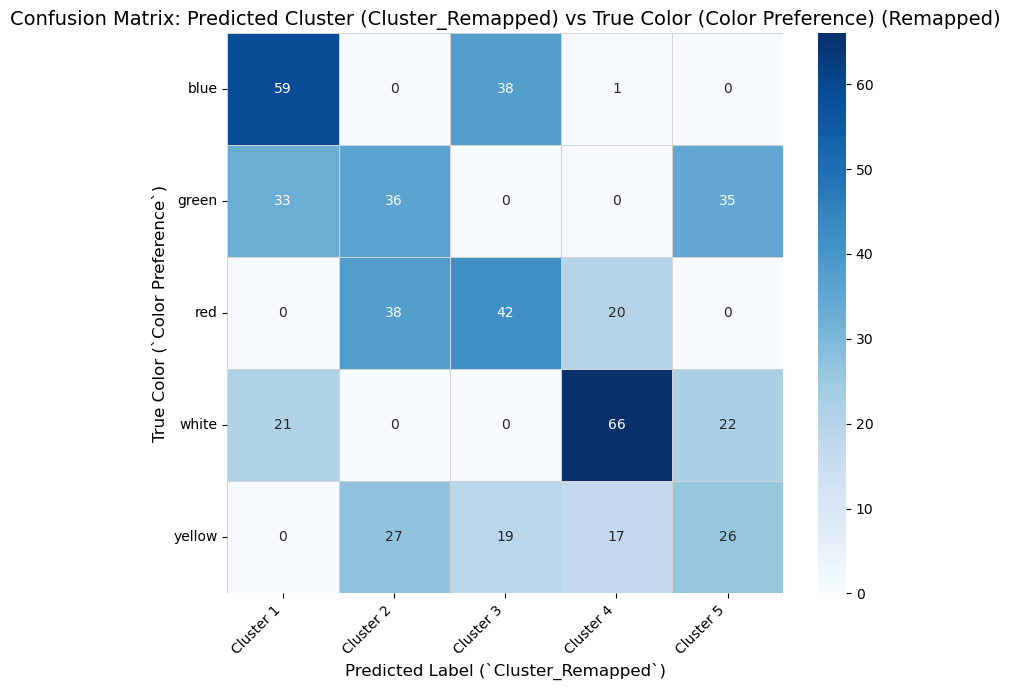

In [21]:
# ==============================================================================
# Imports
# ==============================================================================
import networkx as nx
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
from typing import List, Dict, Set, Tuple, Any, Optional
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack as sparse_hstack
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment # For optimal remapping
import time
import os
import warnings

# <<< NEW IMPORTS for Deep Learning Sequence Processing >>>
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Masking, Input
from tensorflow.keras.utils import pad_sequences # <<< Corrected Import
# <<< END NEW IMPORTS >>>

# Set random seed for TensorFlow for reproducibility (optional)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# ==============================================================================
# Agent Definition
# ==============================================================================
class Agent:
    """ Agent with Preference-Driven Goal: Find N preferred nodes using
        Deterministic Preference strategy (always choose preferred if available). """
    def __init__(self, start_node: int, color_preference: str,
                 target_preferred_count: int, max_steps: int):
        self.start_node: int = start_node; self.color_preference: str = color_preference
        self.target_preferred_count: int = target_preferred_count; self.max_steps: int = max_steps
        self.current_node: int = start_node; self.visited_nodes: Set[int] = {start_node}
        self.path: List[int] = [start_node]; self.preferred_nodes_visited: Set[int] = set()
        self.visited_shapes: List[str] = []; self.visited_shininess: List[str] = []

    def find_next_node(self, graph: nx.Graph, rng: random.Random) -> Optional[int]:
        """
        Determines the next node using a DETERMINISTIC PREFERENCE strategy.
        (Using explicit loop for robustness against potential NameError).
        """
        neighbors = list(graph.neighbors(self.current_node))
        valid_neighbors = [n for n in neighbors if n in graph]
        unvisited_neighbors = [n for n in valid_neighbors if n not in self.visited_nodes]

        if not unvisited_neighbors:
            return None # Stuck

        preferred_unvisited_neighbors = []
        non_preferred_unvisited_neighbors = [] # Keep track for the else case

        for neigh_node in unvisited_neighbors:
            try:
                node_attrs = graph.nodes.get(neigh_node, {})
                node_color = node_attrs.get('color')
                if node_color == self.color_preference:
                    preferred_unvisited_neighbors.append(neigh_node)
                else:
                    non_preferred_unvisited_neighbors.append(neigh_node)
            except Exception as e_inner:
                print(f"  ERROR accessing node {neigh_node} attributes: {repr(e_inner)}")
                non_preferred_unvisited_neighbors.append(neigh_node)

        if preferred_unvisited_neighbors:
            return rng.choice(preferred_unvisited_neighbors)
        elif non_preferred_unvisited_neighbors:
            return rng.choice(non_preferred_unvisited_neighbors)
        else:
            print(f" Warning: Agent at {self.current_node} has no valid unvisited neighbors to move to. Stuck.")
            return None # Truly stuck

    def traverse_graph(self, graph: nx.Graph, rng: random.Random) -> Tuple[List[int], int, int]:
        """ Simulates exploration walk using deterministic preference strategy. """
        steps_taken = 0; self.preferred_nodes_visited = set()
        try:
            start_node_attrs = graph.nodes[self.start_node]; self.visited_shapes.append(start_node_attrs.get('shape', 'unknown')); self.visited_shininess.append(start_node_attrs.get('shiny', 'unknown'))
            if start_node_attrs.get('color') == self.color_preference: self.preferred_nodes_visited.add(self.start_node)
        except KeyError: self.visited_shapes.append('unknown'); self.visited_shininess.append('unknown')

        while len(self.preferred_nodes_visited) < self.target_preferred_count and steps_taken < self.max_steps:
            next_node = self.find_next_node(graph, rng)
            if next_node is None: break
            self.visited_nodes.add(next_node); self.path.append(next_node); self.current_node = next_node; steps_taken += 1
            try:
                node_attrs = graph.nodes[next_node]; self.visited_shapes.append(node_attrs.get('shape', 'unknown')); self.visited_shininess.append(node_attrs.get('shiny', 'unknown'))
                if node_attrs.get('color') == self.color_preference: self.preferred_nodes_visited.add(next_node)
            except KeyError: self.visited_shapes.append('unknown'); self.visited_shininess.append('unknown')

        preferred_nodes_found_count = len(self.preferred_nodes_visited)
        return self.path, preferred_nodes_found_count, steps_taken

# ==============================================================================
# Graph Generation
# ==============================================================================
def generate_structured_colored_graph(num_nodes: int, colors: List[str], edge_probability: float, structure_seed: int, edge_seed: int, noise_level: float = 0.1) -> nx.Graph:
    G = nx.Graph(); num_colors = len(colors);
    if num_colors == 0: raise ValueError("Color list empty.");
    if not 0.0 <= noise_level <= 1.0: raise ValueError("Noise level invalid.")
    nodes_per_region = num_nodes // num_colors; region_rng = random.Random(structure_seed); node_assignments = {}
    nodes_list = list(range(1, num_nodes + 1)); region_rng.shuffle(nodes_list)
    print(f"  Assigning {num_nodes} nodes to {num_colors} color regions (Noise: {noise_level*100:.1f}%)...")
    for i, node_id in enumerate(nodes_list):
        region_index = min(i // nodes_per_region, num_colors - 1); base_color = colors[region_index]; final_color = base_color
        if noise_level > 0 and region_rng.random() < noise_level:
            possible_noise_colors = [c for c in colors if c != base_color]
            if possible_noise_colors: final_color = region_rng.choice(possible_noise_colors)
        node_assignments[node_id] = final_color
    shape_rng = random.Random(structure_seed + 1); shapes = ['circle', 'square', 'triangle']; shininess_options = ['shiny', 'not_shiny']
    for i in range(1, num_nodes + 1):
          shape = shape_rng.choice(shapes); shininess = shape_rng.choice(shininess_options)
          G.add_node(i, color=node_assignments[i], shape=shape, shiny=shininess)
    edge_rng = random.Random(edge_seed); edge_count = 0
    for i in range(1, num_nodes + 1):
        for j in range(i + 1, num_nodes + 1):
            if edge_rng.random() < edge_probability: G.add_edge(i, j); edge_count += 1
    if num_nodes > 0 and not nx.is_connected(G): warnings.warn(f"Generated graph (seed {structure_seed}) not connected.", stacklevel=2)
    return G

# ==============================================================================
# Simulation
# ==============================================================================
def simulate_agents(graph: nx.Graph, num_agents: int, num_traversals_per_agent: int, simulation_seed: int, edge_probability: float, target_preferred_count: int, max_steps: int, colors_list: List[str] = ['blue', 'green', 'red', 'yellow']) -> pd.DataFrame:
    agent_data = []; node_id_to_color_name = {node: graph.nodes[node].get('color', 'unknown') for node in graph.nodes()}
    sim_rng = random.Random(simulation_seed); print(f" Starting simulations for Seed {simulation_seed}...")
    total_simulations = num_agents * num_traversals_per_agent; completed_simulations = 0; skipped_simulations = 0
    print(f"  NOTE: Agent goal: Find {target_preferred_count} preferred nodes (max {max_steps} steps)."); print("  NOTE: Agent using DETERMINISTIC PREFERENCE strategy.");
    nodes_list = list(graph.nodes())
    if not nodes_list: print(" Error: Graph has no nodes."); return pd.DataFrame(agent_data)
    for i in range(total_simulations):
        agent_id = i % num_agents; start_node = sim_rng.choice(nodes_list); color_preference = sim_rng.choice(colors_list)
        agent = Agent(start_node, color_preference, target_preferred_count, max_steps)
        try: path, preferred_nodes_found, steps_taken = agent.traverse_graph(graph, sim_rng); # Call fixed Agent V5
        except Exception as e: print(f" Error during agent traversal call (Start: {start_node}, Pref: {color_preference}): {repr(e)}"); skipped_simulations += 1; continue
        if not path: print(f"  Warning: Traversal returned empty path (Start: {start_node}). Skipping."); skipped_simulations += 1; continue
        mapped_colors = [node_id_to_color_name.get(node, 'unknown') for node in agent.path]; path_len = len(agent.path); preferred_color_path_count = sum(1 for node in agent.path if graph.nodes.get(node, {}).get('color') == agent.color_preference); pref_prop = (preferred_color_path_count / path_len) if path_len > 0 else 0.0
        agent_data.append({'Seed': simulation_seed, 'Agent': agent_id, 'Start Node': start_node, 'Color Preference': color_preference, 'Target Preferred Count': target_preferred_count, 'Max Steps': max_steps, 'Actual Steps Taken': steps_taken, 'Preferred Nodes Found': preferred_nodes_found, 'Path Length': path_len, 'Preferred Color Path Count': preferred_color_path_count, 'Preferred_Color_Proportion': pref_prop, 'Path': agent.path, 'Mapped Colors': mapped_colors, 'Visited Shapes': agent.visited_shapes, 'Visited Shininess': agent.visited_shininess, 'Density': edge_probability }); completed_simulations += 1
    print(f"  Finished simulations for Seed {simulation_seed}. Completed: {completed_simulations}, Skipped: {skipped_simulations}")
    return pd.DataFrame(agent_data)

# ==============================================================================
# Clustering Feature Engineering / Distance Calculation 
# ==============================================================================

# --- Jaccard ---
def jaccard_distance(set1: Any, set2: Any) -> float:
    try: set1 = set(set1) if isinstance(set1, (list, tuple, np.ndarray)) else set(set1) if set1 is not None else set(); set2 = set(set2) if isinstance(set2, (list, tuple, np.ndarray)) else set(set2) if set2 is not None else set()
    except TypeError: return 1.0
    intersection = len(set1.intersection(set2)); union = len(set1.union(set2));
    if union == 0: return 0.0
    return 1.0 - intersection / union

# --- BoC ---
def extract_boc_features(group: pd.DataFrame) -> Optional[Any]:
     if 'Mapped Colors' not in group.columns: print("Error:'Mapped Colors'"); return None
     group['Mapped Colors'] = group['Mapped Colors'].apply(lambda x: x if isinstance(x, list) else []) # Ensure list
     corpus = group['Mapped Colors'].apply(lambda colors: ' '.join(map(str, colors)))
     try: vectorizer = CountVectorizer(); X = vectorizer.fit_transform(corpus); print(f"  BoC Features extracted with shape: {X.shape}"); return X
     except Exception as e: print(f"  Error extracting BoC features: {e}"); return None

# --- Combined BoC + Numerical ---
def extract_combined_features(group: pd.DataFrame) -> Optional[Any]:
    print("  Extracting Combined Features (BoC + Numerical)..."); boc_features = extract_boc_features(group);
    if boc_features is None: return None
    num_cols = ['Path Length', 'Preferred_Color_Proportion'] # Ensure these cols exist
    if not all(col in group.columns for col in num_cols): print(f"Error: Missing {num_cols}"); return None
    try: numerical_features = group[num_cols].values.astype(float)
    except Exception as e: print(f"Error accessing numerical features: {e}"); return None
    try: scaler = StandardScaler(); scaled_numerical = scaler.fit_transform(numerical_features)
    except Exception as e: print(f"Error scaling numerical features: {e}"); return None
    try: combined_features = sparse_hstack((boc_features.tocsr(), scaled_numerical), format='csr'); print(f"  Combined Features shape: {combined_features.shape}"); return combined_features
    except Exception as e: print(f"Error combining features: {e}"); return None

# --- <<< Deep Learning Sequence Feature Extraction >>> ---
def extract_sequence_features_dl(group: pd.DataFrame,
                                 color_vocab: List[str],
                                 max_seq_len: int,
                                 embedding_dim: int,
                                 lstm_units: int,
                                 seed: int = 42) -> Optional[np.ndarray]:
    """
    Extracts features from color sequences using an Embedding + LSTM model.
    """
    print(f"  Extracting Sequence Features using DL (MaxLen={max_seq_len}, Embed={embedding_dim}, LSTM={lstm_units})...")
    if 'Mapped Colors' not in group.columns:
        print("  Error: 'Mapped Colors' column not found in group.")
        return None

    # 1. Preprocessing
    # Create color -> integer mapping (reserve 0 for padding)
    color_to_int = {color: i + 1 for i, color in enumerate(color_vocab)}
    vocab_size = len(color_vocab) + 1 # Add 1 for the padding token

    # Convert color sequences to integer sequences
    sequences = group['Mapped Colors'].apply(lambda x: [color_to_int.get(c, 0) for c in x] if isinstance(x, list) else [0])
    # Pad sequences
    padded_sequences = pad_sequences(sequences, maxlen=max_seq_len, padding='post', truncating='post', value=0)
    print(f"   - Padded sequences shape: {padded_sequences.shape}")

    if padded_sequences.shape[0] == 0:
        print("  Error: No valid sequences after padding.")
        return None

    # 2. Model Definition
    # Ensures reproducibility within this function call
    tf.random.set_seed(seed)

    # Use Input layer to handle potential variable input length if not using max_seq_len strictly
    # Using input_length in Embedding is also fine since we pad
    model = Sequential([
        Input(shape=(max_seq_len,), dtype='int32'),
        # Masking layer is crucial if using variable length sequences,
        # but Embedding(mask_zero=True) does this implicitly for value 0
        # Masking(mask_value=0.), # Alternative/Explicit way
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  input_length=max_seq_len, # Necessary if first layer
                  mask_zero=True), # Important: Ignores padding in subsequent layers
        # Use LSTM or GRU. GRU is slightly simpler/faster often.
        # return_sequences=False to get only the last output state
        LSTM(units=lstm_units, return_sequences=False),
        # Optional: Add Dense layers for further transformation
        # Dense(units=lstm_units // 2, activation='relu'),
        # Dense(units=feature_output_dim) # If specific output size needed
    ], name=f"SequenceFeatureExtractor_Seed{seed}")

    # Compile is not strictly needed for prediction only, but good practice
    # model.compile(optimizer='adam', loss='sparse_categorical_crossentropy') # Loss irrelevant here
    # print(model.summary()) # Optional: Print model structure

    # 3. Feature Extraction
    try:
        print("   - Predicting features with DL model...")
        # Ensure input is suitable type (numpy array)
        features = model.predict(padded_sequences, verbose=0)
        print(f"   - Extracted DL Features shape: {features.shape}")
        if not np.isfinite(features).all():
            warnings.warn(f"NaN or Inf found in extracted DL features (Seed {seed}). Replacing with 0.", stacklevel=2)
            features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
        return features
    except Exception as e:
        print(f"  Error during DL model prediction: {e}")
        import traceback
        traceback.print_exc() # Print detailed error
        return None
# --- <<< END NEW DL FEATURE FUNCTION >>> ---


# --- calculate_distance_matrix  ---
def calculate_distance_matrix(group: pd.DataFrame,
                               method: str = 'jaccard',
                               # DL specific params (passed via kwargs)
                               color_vocab: Optional[List[str]] = None,
                               max_seq_len: Optional[int] = None,
                               embedding_dim: Optional[int] = None,
                               lstm_units: Optional[int] = None,
                               seed: int = 42,
                               **kwargs) -> Tuple[Optional[np.ndarray], Optional[Any], bool, str]:
    """
    Calculates distance matrix or extracts features based on the specified method.
    Now includes 'sequence_dl' method.
    """
    num_samples = len(group); metric_used = method; distance_matrix = None; feature_matrix = None; is_valid = False

    if method == 'jaccard':
        # --- Jaccard calculation (unchanged) ---
        metric_used = 'jaccard';
        if 'Path' not in group.columns: print("Error:'Path'"); return None, None, False, metric_used
        group['Path_Set'] = group['Path'].apply(lambda x: set(x) if isinstance(x, (list, tuple)) else set())
        distance_matrix_calc = np.zeros((num_samples, num_samples)); path_sets = group['Path_Set'].tolist()
        for i in range(num_samples):
            for j in range(i + 1, num_samples):
                try: dist = jaccard_distance(path_sets[i], path_sets[j]);
                except Exception as e: print(f"Error Jaccard({i},{j}): {e}"); return None, None, False, metric_used
                if not np.isfinite(dist): raise ValueError(f"Invalid Jaccard dist: {dist}")
                distance_matrix_calc[i, j] = dist; distance_matrix_calc[j, i] = dist
        distance_matrix = distance_matrix_calc; is_valid = True
    elif method == 'boc':
        # --- BoC calculation (unchanged) ---
        metric_used = kwargs.get('metric', 'cosine'); feature_matrix = extract_boc_features(group)
        if feature_matrix is not None:
            try: condensed_distances = pdist(feature_matrix.toarray(), metric=metric_used); distance_matrix = squareform(condensed_distances); print(f"  BoC Features + '{metric_used}' distance matrix calculated."); is_valid = True
            except Exception as e: print(f"Warn: Could not create distance matrix from BoC: {e}"); is_valid = False # Changed to False on error
        else: return None, None, False, 'boc'
    elif method == 'combined':
        # --- Combined features (unchanged) ---
         metric_used = kwargs.get('metric', 'euclidean'); feature_matrix = extract_combined_features(group)
         if feature_matrix is not None: is_valid = True; distance_matrix = None; print(f"  Combined features extracted. Assoc metric: '{metric_used}'")
         else: is_valid = False
         # Return features directly for combined method
         return distance_matrix, feature_matrix, is_valid, metric_used

    # --- <<< NEW: Handle 'sequence_dl' method >>> ---
    elif method == 'sequence_dl':
        metric_used = kwargs.get('metric', 'euclidean') # Metric for evaluating clusters based on these features
        if not all([color_vocab, max_seq_len, embedding_dim, lstm_units]):
             print("Error: Missing DL parameters (color_vocab, max_seq_len, embedding_dim, lstm_units) for 'sequence_dl'.")
             return None, None, False, 'sequence_dl'

        feature_matrix = extract_sequence_features_dl(group, color_vocab, max_seq_len, embedding_dim, lstm_units, seed=seed)

        if feature_matrix is not None:
            print(f"  Sequence DL features extracted. Associated metric for clustering: '{metric_used}'")
            is_valid = True
            distance_matrix = None # Features extracted, not distances directly
        else:
            print("Error: Failed to extract sequence DL features.")
            is_valid = False
        # Return features for DL method
        return distance_matrix, feature_matrix, is_valid, metric_used
    # --- <<< END NEW DL METHOD HANDLING >>> ---

    else: print(f"Error: Unknown method '{method}'."); return None, None, False, 'unknown'

    # Return distance matrix (for jaccard/boc) or feature matrix (for combined/dl)
    return distance_matrix, feature_matrix, is_valid, metric_used


# ==============================================================================
# Clustering and Evaluation Function 
# ==============================================================================
def cluster_and_evaluate(df: pd.DataFrame,
                         n_clusters: int = 4,
                         feature_distance_method: str = 'jaccard',
                         cluster_method: str = 'ward',
                         dist_metric_param: str = 'cosine', # Metric for BoC distances or DL feature eval
                         linkage_method: str = 'ward', # Used by hierarchical
                         # DL specific params
                         color_vocab: Optional[List[str]] = None,
                         max_seq_len: Optional[int] = None,
                         embedding_dim: Optional[int] = None,
                         lstm_units: Optional[int] = None,
                         ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Performs clustering and evaluation, now supporting 'sequence_dl' features.
    """
    required_cols = ['Seed', 'Color Preference', 'Mapped Colors'] # Base required
    # Adjust required cols check based on feature method
    if feature_distance_method == 'jaccard': required_cols.append('Path')
    elif feature_distance_method == 'combined': required_cols.extend(['Path Length', 'Preferred Color Path Count', 'Path', 'Mapped Colors'])
    elif feature_distance_method == 'boc': required_cols.extend(['Path', 'Mapped Colors'])
    elif feature_distance_method == 'sequence_dl': required_cols.append('Mapped Colors') # Only need sequences

    if not all(col in df.columns for col in required_cols):
        missing = [col for col in required_cols if col not in df.columns]
        raise ValueError(f"Missing columns for eval: {missing}. Available: {df.columns.tolist()}")

    print(f"\n--- Starting Clustering Evaluation ---");
    print(f" Feature/Distance Method: {feature_distance_method}");
    print(f" Clustering Algorithm: {cluster_method}");
    print(f" Target Clusters (k): {n_clusters}")
    if feature_distance_method == 'sequence_dl':
        print(f" DL Params: MaxLen={max_seq_len}, Embed={embedding_dim}, LSTM={lstm_units}")


    results_summary = []; processed_groups = []
    for seed, group in df.groupby('Seed'):
        print(f" Processing Seed {seed}..."); group = group.copy(); num_samples = len(group); group['Cluster'] = -1
        if num_samples < 2: print(f"  Skipping Seed {seed}: Samples < 2."); processed_groups.append(group); continue

        # --- Call calculate_distance_matrix (handles all methods) ---
        distance_matrix, feature_matrix, is_valid, eval_metric = calculate_distance_matrix(
            group,
            method=feature_distance_method,
            metric=dist_metric_param, # Passed as kwarg
            # Pass DL params if method is 'sequence_dl'
            color_vocab=color_vocab,
            max_seq_len=max_seq_len,
            embedding_dim=embedding_dim,
            lstm_units=lstm_units,
            seed=seed # Pass seed for reproducibility in DL feature extraction
        )

        if not is_valid:
            print(f"  Skipping Seed {seed}: Feature/Distance calculation failed or invalid.")
            processed_groups.append(group); continue

        # Determine if we primarily have features or distances
        # DL method *always* returns features.
        # Combined method *always* returns features.
        # Jaccard *always* returns distances.
        # BoC *can* return features or distances, but we usually use features now.
        has_features = feature_matrix is not None
        has_distances = distance_matrix is not None

        clusters = None; actual_n_clusters = min(n_clusters, num_samples) if num_samples > 0 else 1;
        if actual_n_clusters < 1: actual_n_clusters = 1

        # --- Clustering Block ---
        try:
            if cluster_method in ['ward', 'complete', 'average', 'single']: # Hierarchical
                 print(f"  Running Hierarchical Clustering ({cluster_method})...")
                 linkage_input_dm = distance_matrix
                 if linkage_input_dm is None: # Need to calculate distances from features
                     if has_features:
                         print(f"   - Calculating '{dist_metric_param}' distance matrix for hierarchical on extracted features...")
                         try:
                             # Use .toarray() if features are sparse (e.g., from BoC/Combined)
                             feature_array = feature_matrix.toarray() if hasattr(feature_matrix, "toarray") else feature_matrix
                             condensed_distances_hier = pdist(feature_array, metric=dist_metric_param)
                             linkage_input_dm = squareform(condensed_distances_hier)
                         except Exception as e_pdist: raise ValueError(f"Failed distance calc for hierarchical: {e_pdist}") from e_pdist
                     else: raise ValueError("Hierarchical clustering selected, but neither distance matrix nor features are available.")

                 # --- Validation checks for distance matrix (mostly unchanged) ---
                 if not isinstance(linkage_input_dm, np.ndarray) or linkage_input_dm.ndim!=2 or linkage_input_dm.shape[0]!=linkage_input_dm.shape[1]: raise ValueError("Invalid DM shape.")
                 if np.isnan(linkage_input_dm).any() or np.isinf(linkage_input_dm).any(): raise ValueError("NaN/Inf in DM.")
                 if not np.allclose(linkage_input_dm, linkage_input_dm.T): warnings.warn(f"DM not symmetric (Seed {seed}). Forcing symmetry.", stacklevel=2); linkage_input_dm = (linkage_input_dm + linkage_input_dm.T) / 2
                 np.fill_diagonal(linkage_input_dm, 0)
                 linkage_input_dm[linkage_input_dm < 0] = 0 # Ensure non-negative distances

                 try: condensed_distance = squareform(linkage_input_dm, checks=True)
                 except ValueError as sq_err: raise ValueError(f"Squareform check failed: {sq_err}") from sq_err
                 if condensed_distance is None or not np.isfinite(condensed_distance).all(): raise ValueError("Invalid condensed distance array.")

                 Z = linkage(condensed_distance, method=cluster_method);
                 if Z is None or not isinstance(Z, np.ndarray): raise TypeError("Linkage failed.")
                 clusters = fcluster(Z, t=actual_n_clusters, criterion='maxclust')
                 if clusters is None or not isinstance(clusters, np.ndarray): raise TypeError("fcluster failed.")
                 clusters = clusters # Already 1-based

            elif cluster_method in ['kmeans', 'gmm']: # Feature-based
                print(f"  Running {cluster_method} Clustering...")
                if not has_features:
                    raise ValueError(f"{cluster_method} requires features, but they were not generated by method '{feature_distance_method}'.")

                # Ensure features are dense numpy array for KMeans/GMM
                feature_array = feature_matrix.toarray() if hasattr(feature_matrix, "toarray") else feature_matrix

                if cluster_method == 'kmeans':
                     # Handle potential NaN/Inf in features before KMeans
                     if not np.isfinite(feature_array).all():
                         warnings.warn(f"NaN/Inf found in features for KMeans (Seed {seed}). Replacing with 0.", stacklevel=2)
                         feature_array = np.nan_to_num(feature_array, nan=0.0, posinf=0.0, neginf=0.0)
                     if feature_array.shape[0] < actual_n_clusters:
                         warnings.warn(f"Samples ({feature_array.shape[0]}) < clusters ({actual_n_clusters}) for KMeans (Seed {seed}). Reducing clusters.", stacklevel=2)
                         actual_n_clusters = max(1, feature_array.shape[0]) # Ensure at least 1 cluster
                     kmeans = KMeans(n_clusters=actual_n_clusters, random_state=seed, n_init=10, verbose=0);
                     clusters = kmeans.fit_predict(feature_array);
                     clusters += 1 # Make 1-based
                elif cluster_method == 'gmm':
                     # Handle potential NaN/Inf in features before GMM
                     if not np.isfinite(feature_array).all():
                         warnings.warn(f"NaN/Inf found in features for GMM (Seed {seed}). Replacing with 0.", stacklevel=2)
                         feature_array = np.nan_to_num(feature_array, nan=0.0, posinf=0.0, neginf=0.0)
                     if feature_array.shape[0] < actual_n_clusters:
                         warnings.warn(f"Samples ({feature_array.shape[0]}) < components ({actual_n_clusters}) for GMM (Seed {seed}). Reducing components.", stacklevel=2)
                         actual_n_clusters = max(1, feature_array.shape[0]) # Ensure at least 1 component
                     gmm = GaussianMixture(n_components=actual_n_clusters, random_state=seed, verbose=0, n_init=5);
                     clusters = gmm.fit_predict(feature_array);
                     clusters += 1 # Make 1-based
            else:
                raise ValueError(f"Unsupported cluster_method: {cluster_method}")

            if clusters is None:
                 raise ValueError("Clustering did not produce cluster assignments.")
            if len(clusters) != num_samples:
                 raise ValueError(f"Number of cluster labels ({len(clusters)}) does not match number of samples ({num_samples}).")

            group['Cluster'] = clusters
            num_unique_clusters_found = len(set(c for c in clusters if c != -1)) # Assuming -1 is noise/unassigned
            print(f"   - Found {num_unique_clusters_found} unique clusters.")

        except Exception as e:
            print(f"  Error during clustering for Seed {seed}: {repr(e)}")
            import traceback
            traceback.print_exc()
            processed_groups.append(group); continue # Skip evaluation if clustering fails

        # --- Evaluation ---
        silhouette_avg = np.nan; ari_score = np.nan; nmi_score = np.nan
        valid_cluster_mask = group['Cluster'] != -1 # Exclude potential noise points (e.g., from DBSCAN if used)
        clusters_for_eval = group.loc[valid_cluster_mask, 'Cluster']
        num_valid_samples_for_eval = len(clusters_for_eval);
        num_clusters_for_eval = len(set(clusters_for_eval))

        # --- Silhouette Score Calculation ---
        if num_clusters_for_eval > 1 and num_clusters_for_eval < num_valid_samples_for_eval:
            print(f"   - Calculating Silhouette Score (using metric: '{eval_metric}')...")
            silhouette_input_data = None
            silhouette_metric_param = 'euclidean' # Default

            if has_distances and eval_metric == 'jaccard': # Use precomputed Jaccard
                 silhouette_metric_param = 'precomputed'
                 silhouette_input_data = distance_matrix
                 print("     (Using precomputed Jaccard distance matrix)")
            elif has_features: # Use features with the specified eval_metric
                 silhouette_metric_param = eval_metric # Use the metric associated with features (e.g., euclidean for DL)
                 silhouette_input_data = feature_matrix
                 print(f"     (Using extracted features)")
            else: # Fallback: calculate distances if only precomputed available but not Jaccard
                 if has_distances:
                     silhouette_metric_param = 'precomputed'
                     silhouette_input_data = distance_matrix
                     print(f"     (Using provided precomputed distance matrix - metric assumed {eval_metric})")


            if silhouette_input_data is not None:
                try:
                    # Get the subset of data corresponding to valid clusters
                    valid_mask_np = valid_cluster_mask.to_numpy()
                    if silhouette_metric_param == 'precomputed':
                        if silhouette_input_data.shape[0] == num_samples:
                            valid_distance_matrix = silhouette_input_data[np.ix_(valid_mask_np, valid_mask_np)]
                            if valid_distance_matrix.shape[0] > 1: # Need at least 2 samples in valid clusters
                                silhouette_avg = silhouette_score(valid_distance_matrix, clusters_for_eval, metric='precomputed')
                            else: print("     Skipping Silhouette: Not enough valid samples after filtering for precomputed.")
                        else: print(f"     Warning: Precomputed matrix shape mismatch ({silhouette_input_data.shape[0]} vs {num_samples}) for Silhouette.")
                    else: # Feature-based silhouette
                        feature_array_eval = silhouette_input_data.toarray() if hasattr(silhouette_input_data, "toarray") else silhouette_input_data
                        if feature_array_eval.shape[0] == num_samples:
                            valid_feature_matrix = feature_array_eval[valid_mask_np]
                            if valid_feature_matrix.shape[0] > 1:
                                # Handle potential NaN/Inf in features before Silhouette
                                if not np.isfinite(valid_feature_matrix).all():
                                     warnings.warn(f"NaN/Inf found in features for Silhouette (Seed {seed}). Replacing with 0.", stacklevel=2)
                                     valid_feature_matrix = np.nan_to_num(valid_feature_matrix, nan=0.0, posinf=0.0, neginf=0.0)
                                silhouette_avg = silhouette_score(valid_feature_matrix, clusters_for_eval, metric=silhouette_metric_param)
                            else: print("     Skipping Silhouette: Not enough valid samples after filtering for feature-based.")
                        else: print(f"     Warning: Feature matrix shape mismatch ({feature_array_eval.shape[0]} vs {num_samples}) for Silhouette.")
                    print(f"     Silhouette Score: {silhouette_avg:.4f}")
                except Exception as e_sil:
                    print(f"    Warning: Silhouette score calculation error (Metric: {silhouette_metric_param}): {repr(e_sil)}")
            else:
                 print(f"    Skipping Silhouette: Suitable input data not available (Seed {seed})")
        elif num_clusters_for_eval <= 1:
             print(f"   - Skipping Silhouette Score: Only {num_clusters_for_eval} cluster(s) found.")
        else: # Not enough samples
             print(f"   - Skipping Silhouette Score: Not enough samples ({num_valid_samples_for_eval}) for {num_clusters_for_eval} clusters.")


        # --- ARI/NMI Calculation (unchanged) ---
        if num_valid_samples_for_eval > 0:
            print("   - Calculating ARI and NMI...")
            try:
                true_labels_for_eval = group.loc[valid_cluster_mask, 'Color Preference'];
                ari_score = adjusted_rand_score(true_labels_for_eval, clusters_for_eval);
                nmi_score = normalized_mutual_info_score(true_labels_for_eval, clusters_for_eval)
                print(f"     ARI: {ari_score:.4f}, NMI: {nmi_score:.4f}")
            except Exception as e_gnd:
                 print(f"    Warning: Could not compute ARI/NMI Seed {seed}: {repr(e_gnd)}")

        # --- Purity/Color Percentage Calculation (unchanged) ---
        formatted_cluster_color_percentages = {}; max_color_separation = np.nan
        try:
            valid_group_for_purity = group[group['Cluster'] != -1]
            if not valid_group_for_purity.empty:
                if 'Mapped Colors' in valid_group_for_purity.columns:
                     # ... (rest of purity calculation code is identical) ...
                     exploded_group = valid_group_for_purity.explode('Mapped Colors').dropna(subset=['Mapped Colors']); exploded_group.rename(columns={'Mapped Colors': 'Flat Colors'}, inplace=True)
                     color_counts = exploded_group.groupby(['Cluster', 'Flat Colors']).size().unstack(fill_value=0)
                     all_possible_colors = sorted(df['Color Preference'].dropna().unique())
                     for color in all_possible_colors:
                         if color not in color_counts.columns: color_counts[color] = 0
                     color_counts = color_counts[all_possible_colors]; cluster_sums = color_counts.sum(axis=1); safe_sums = cluster_sums.replace(0, 1)
                     color_percentages = color_counts.div(safe_sums, axis=0).mul(100); cluster_color_percentages_dict = color_percentages.round(2).apply(lambda r: r.dropna().to_dict(), axis=1).to_dict()
                     formatted_cluster_color_percentages = {int(k): {c: f"{p:.2f}%" for c, p in v.items()} for k, v in cluster_color_percentages_dict.items()}
                     if not color_percentages.empty: max_color_separation = color_percentages.apply(lambda r: r.max() - r.min() if not r.empty else 0.0, axis=1).max()
                     else: max_color_separation = 0.0
                else: print(f"    Warning: 'Mapped Colors' column missing for purity calc (Seed {seed}).")
        except Exception as e: print(f"    Warning: Color percentage error Seed {seed}: {e}")

        results_summary.append({
            'Seed': seed,
            'Algorithm': cluster_method,
            'Feature_Metric': f"{feature_distance_method}({eval_metric})",
            'Num_Clusters_Target': n_clusters,
            'Num_Clusters_Found': num_clusters_for_eval,
            'Cluster_Color_Percentage': formatted_cluster_color_percentages,
            'Silhouette': silhouette_avg,
            'ARI': ari_score,
            'NMI': nmi_score,
            'Max_Color_Separation': max_color_separation
        })
        processed_groups.append(group) # Add group with cluster assignments

    # Combine results
    if not processed_groups: warnings.warn("No groups processed."); return pd.DataFrame(results_summary), df.copy()
    df_with_clusters = pd.concat(processed_groups).reset_index(drop=True);
    results_summary_df = pd.DataFrame(results_summary)
    print("\nClustering and evaluation complete.")
    return results_summary_df, df_with_clusters


# ==============================================================================
# Plotting Functions
# ==============================================================================
def plot_colored_graph(G: nx.Graph, seed: int, output_dir: str = "plots"):
     if not os.path.exists(output_dir): os.makedirs(output_dir); filepath = os.path.join(output_dir, f"graph_seed_{seed}.png")
     plt.figure(figsize=(12, 10)); pos = nx.spring_layout(G, seed=42); node_colors = [G.nodes[node].get('color', 'gray') for node in G.nodes()]
     nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=200, alpha=0.9); nx.draw_networkx_edges(G, pos, alpha=0.3)
     plt.title(f"Graph Structure (Seed {seed})", fontsize=16); plt.axis('off'); plt.tight_layout(); plt.savefig(filepath); print(f" Saved graph plot to {filepath}"); plt.close()

def plot_color_confusion_matrix(df: pd.DataFrame, cluster_col: str = 'Cluster', true_color_col: str = 'Color Preference', figsize: Tuple[int, int] = (8, 7), cmap: str = 'Blues', output_dir: str = "plots"):
     if not os.path.exists(output_dir): os.makedirs(output_dir); plot_filename = f"confusion_matrix_{cluster_col}_vs_{true_color_col}.png"; filepath = os.path.join(output_dir, plot_filename)
     if cluster_col not in df.columns: raise ValueError(f"Cluster column '{cluster_col}' not found.")
     if true_color_col not in df.columns: raise ValueError(f"True color column '{true_color_col}' not found.")
     # Ensure cluster column is numeric, handle potential non-numeric values
     df[cluster_col] = pd.to_numeric(df[cluster_col], errors='coerce')
     df_valid = df.dropna(subset=[cluster_col]).copy() # Drop rows where cluster is NaN after coercion
     df_valid[cluster_col] = df_valid[cluster_col].astype(int);
     # Filter based on meaningful cluster IDs (e.g., > 0 if -1 is noise)
     df_valid = df_valid[df_valid[cluster_col] > 0] # Assuming clusters are 1-based

     if df_valid.empty: print(f"Warning: No valid data for confusion matrix (Cluster Col: {cluster_col})."); return

     unique_colors = sorted(df_valid[true_color_col].dropna().unique());
     if not unique_colors: print(f"Error: No valid unique values in '{true_color_col}'."); return

     # Use actual unique cluster labels found for columns if remapping isn't perfect
     unique_pred_labels_found = sorted(df_valid[cluster_col].unique())
     if not unique_pred_labels_found:
         print(f"Error: No valid unique predicted cluster labels found in '{cluster_col}'."); return

     # Map true colors to integers for rows
     color_to_int_mapping = {color: i + 1 for i, color in enumerate(unique_colors)};
     int_to_color_mapping = {v: k for k,v in color_to_int_mapping.items()}
     row_labels_int = list(color_to_int_mapping.values())
     row_labels_names = [int_to_color_mapping.get(i, f'Unknown {i}') for i in row_labels_int]


     print(f"\n--- Confusion Matrix Generation ({cluster_col} vs {true_color_col}) ---");
     print(f" Using True Color Mapping for Plot Rows: {color_to_int_mapping}")
     print(f" Using Predicted Cluster Labels for Plot Columns: {unique_pred_labels_found}")

     try:
         y_true = df_valid[true_color_col].map(color_to_int_mapping);
         y_pred = df_valid[cluster_col] # Already filtered to be integers > 0
     except Exception as e: print(f" Error preparing y_true/y_pred: {e}"); return

     valid_indices = y_true.notna()
     y_true = y_true[valid_indices].astype(int);
     y_pred = y_pred[valid_indices]

     if len(y_true) == 0: print(" Error: No samples left for confusion matrix after filtering NAs."); return

     # Ensure labels cover the range of observed true and predicted values
     all_row_labels = sorted(list(set(row_labels_int).union(set(y_true.unique()))))
     all_col_labels = sorted(list(set(unique_pred_labels_found).union(set(y_pred.unique()))))


     conf_matrix = confusion_matrix(y_true, y_pred, labels=all_row_labels)
     # Pad columns if necessary if prediction didn't yield all possible cluster numbers
     if conf_matrix.shape[1] < len(all_col_labels):
         padded_matrix = np.zeros((conf_matrix.shape[0], len(all_col_labels)), dtype=int)
         # Find indices corresponding to existing columns
         existing_cols_indices = [all_col_labels.index(label) for label in sorted(y_pred.unique()) if label in all_col_labels]
         padded_matrix[:, existing_cols_indices] = conf_matrix
         conf_matrix = padded_matrix

     # Ensure consistent row/col names for the DataFrame
     row_names = [int_to_color_mapping.get(i, f'Err {i}') for i in all_row_labels]
     col_names = [f"Cluster {i}" for i in all_col_labels] # Use generic "Cluster X" for columns

     conf_matrix_df = pd.DataFrame(conf_matrix, index=row_names, columns=col_names)

     plt.figure(figsize=figsize); sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap=cmap, cbar=True, linewidths=.5, linecolor='lightgray', annot_kws={"size": 10})
     title = f'Confusion Matrix: Predicted Cluster ({cluster_col}) vs True Color ({true_color_col})'
     if 'Remapped' in cluster_col: title += " (Remapped)"
     plt.title(title, fontsize=14); plt.ylabel(f'True Color (`{true_color_col}`)', fontsize=12); plt.xlabel(f'Predicted Label (`{cluster_col}`)', fontsize=12)
     plt.xticks(rotation=45, ha='right', fontsize=10); plt.yticks(rotation=0, fontsize=10)
     plt.tight_layout(); plt.savefig(filepath); print(f" Saved confusion matrix plot to {filepath}"); plt.close()

# ==============================================================================
# Main Execution Block -> Using SEQUENCE_DL + KMEANS
# ==============================================================================
if __name__ == "__main__":

    # --- Parameters ---
    NUM_NODES = 40; COLORS = ['blue', 'green', 'red', 'yellow', 'white']; EDGE_PROBABILITY = 0.20
    NUM_SEEDS = 5 # Reduced for faster testing of DL
    NUM_AGENTS = 5; NUM_TRAVERSALS_PER_AGENT = 20; # Reduced for faster testing

    # --- Simulation Parameters ---
    TARGET_PREFERRED_COUNT = 5 # Agent goal
    MAX_STEPS = 30             # Step limit (Reduced slightly for potentially shorter sequences)
    GRAPH_NOISE_LEVEL = 0.0

    # --- <<< NEW: Deep Learning Parameters >>> ---
    # Determine MAX_SEQ_LEN: Analyze typical path lengths or set a fixed cap
    # MAX_SEQ_LEN = MAX_STEPS + 1 # A reasonable upper bound based on simulation limit + start node
    # OR analyze data first if running simulation separately:
    # path_lengths = all_simulation_data['Path Length']
    # MAX_SEQ_LEN = int(path_lengths.quantile(0.95)) # e.g., 95th percentile
    MAX_SEQ_LEN = 35 # Set fixed based on slightly above MAX_STEPS for now
    EMBEDDING_DIM = 16 # Dimension of color embeddings
    LSTM_UNITS = 32    # Number of units in the LSTM layer (size of feature vector)

    # --- Clustering Set to SEQUENCE_DL + KMEANS ---
    N_CLUSTERS = len(COLORS) # Match number of expected preference groups
    FEATURE_DISTANCE_METHOD = 'sequence_dl' # <<< USE THE NEW METHOD >>>
    CLUSTER_METHOD = 'kmeans'              # KMeans works directly on features
    DIST_METRIC = 'euclidean'              # Metric used by KMeans and for Silhouette on features

    # --- Output Directory ---
    OUTPUT_DIR = f"clustering_results_{FEATURE_DISTANCE_METHOD}_lstm{LSTM_UNITS}_embed{EMBEDDING_DIM}_k{N_CLUSTERS}"
    if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)

    # --- Run Simulation (Unchanged) ---
    print(f"--- Starting Simulation Phase ---")
    all_results_list = []; start_time_sim = time.time()
    for seed in range(NUM_SEEDS):
        graph_attribute_seed = seed; graph_edge_seed = seed + NUM_SEEDS
        print(f"\nGenerating structured graph for Seed {seed}...")
        G = generate_structured_colored_graph(NUM_NODES, COLORS, EDGE_PROBABILITY,
                                              graph_attribute_seed, graph_edge_seed,
                                              noise_level=GRAPH_NOISE_LEVEL)
        print(f"Running Simulation for Seed {seed}...")
        simulation_seed = seed
        df_agents = simulate_agents(G, NUM_AGENTS, NUM_TRAVERSALS_PER_AGENT,
                                    simulation_seed, EDGE_PROBABILITY,
                                    target_preferred_count=TARGET_PREFERRED_COUNT,
                                    max_steps=MAX_STEPS,
                                    colors_list=COLORS)
        all_results_list.append(df_agents)
    all_simulation_data = pd.concat(all_results_list, ignore_index=True); end_time_sim = time.time()
    print(f"\n--- Simulation Phase Complete ---"); print(f"Generated {len(all_simulation_data)} records in {end_time_sim - start_time_sim:.2f}s.")
    print(f"Path Length Stats:\n{all_simulation_data['Path Length'].describe()}")

    # Check if simulation produced data
    if all_simulation_data.empty:
         print("\nERROR: Simulation produced no data. Exiting.")
    else:
        # --- Run Clustering and Evaluation ---
        print(f"\n--- Starting Clustering Phase using {FEATURE_DISTANCE_METHOD} features ---"); start_time_cluster = time.time()
        summary_results, data_with_clusters = cluster_and_evaluate(
            all_simulation_data.copy(),
            n_clusters=N_CLUSTERS,
            feature_distance_method=FEATURE_DISTANCE_METHOD,
            cluster_method=CLUSTER_METHOD,
            dist_metric_param=DIST_METRIC, # Pass the metric for Silhouette
            # Pass DL parameters explicitly
            color_vocab=COLORS,
            max_seq_len=MAX_SEQ_LEN,
            embedding_dim=EMBEDDING_DIM,
            lstm_units=LSTM_UNITS
        )
        end_time_cluster = time.time(); print(f"\n--- Clustering Phase Complete ---"); print(f"Completed in {end_time_cluster - start_time_cluster:.2f}s.")

        # --- Display and Save Results (Unchanged) ---
        print("\n--- Clustering Summary Results ---"); pd.set_option('display.max_rows', 50); pd.set_option('display.max_columns', None); pd.set_option('display.width', 120); pd.set_option('display.max_colwidth', 150)
        if not summary_results.empty:
            print(summary_results.round(4).to_string()); avg_ari = summary_results['ARI'].mean(); avg_nmi = summary_results['NMI'].mean(); avg_silhouette = summary_results['Silhouette'].mean()
            print("-" * 50); print(f"Avg ARI: {avg_ari:.4f}"); print(f"Avg NMI: {avg_nmi:.4f}"); print(f"Avg Silhouette: {avg_silhouette:.4f}"); print("-" * 50)
            summary_filename = f"summary_{FEATURE_DISTANCE_METHOD}_lstm{LSTM_UNITS}_k{N_CLUSTERS}.csv"
            summary_filepath = os.path.join(OUTPUT_DIR, summary_filename)
            try: summary_results.to_csv(summary_filepath, index=False); print(f"Summary results saved to {summary_filepath}")
            except Exception as e: print(f"Error saving summary: {e}")
        else: print("No summary results generated.")


        # --- Generate and Save Confusion Matrix (with Optimal Remapping - Unchanged Logic) ---
        if not data_with_clusters.empty and 'Cluster' in data_with_clusters.columns and data_with_clusters['Cluster'].max() > 0 :
             print("\n--- Remapping cluster labels for optimal visualization using Hungarian algorithm ---")
             try:
                 valid_clusters_df = data_with_clusters[data_with_clusters['Cluster'] > 0].copy()
                 if valid_clusters_df.empty: raise ValueError("No valid clusters found after filtering for remapping.")

                 unique_colors = sorted(data_with_clusters['Color Preference'].dropna().unique())
                 true_color_to_plot_int = {color: i + 1 for i, color in enumerate(unique_colors)}
                 plot_int_to_true_color = {v: k for k,v in true_color_to_plot_int.items()}
                 plot_labels_ordered = [plot_int_to_true_color.get(i, f'Unknown {i}') for i in range(1, len(unique_colors) + 1)]
                 print(f"  Target Plot Order Mapping: {true_color_to_plot_int}")

                 y_true_numeric_target_order = valid_clusters_df['Color Preference'].map(true_color_to_plot_int)
                 y_pred_original_cluster_labels = valid_clusters_df['Cluster']

                 # Labels for confusion_matrix calculation need to encompass all possibilities up to k
                 k = N_CLUSTERS
                 matrix_calc_labels_true = list(range(1, k + 1)) # Expected true labels 1..k
                 matrix_calc_labels_pred = sorted(y_pred_original_cluster_labels.unique()) # Actual predicted labels

                 # Create matrix with consistent labels
                 raw_cm = confusion_matrix(y_true_numeric_target_order.dropna(),
                                           y_pred_original_cluster_labels.loc[y_true_numeric_target_order.notna()],
                                           labels=matrix_calc_labels_true) # Rows correspond to true target ints

                 # Adjust columns if prediction labels don't match 1..k exactly
                 # This part might need refinement depending on how Hungarian algorithm handles non-square
                 print("  Raw Confusion Matrix (Rows: True Target Int, Cols: Based on Observed Pred Labels):")
                 print(raw_cm)


                 # Cost matrix for Hungarian algorithm: maximize overlap = minimize negative counts
                 # Need to ensure cost matrix aligns with labels properly
                 # We want to map predicted clusters (columns of raw_cm potentially) to true labels (rows)
                 cost_matrix = -raw_cm # Shape: (n_true_labels, n_pred_labels_observed) -> Make square if needed?

                 # Pad cost matrix if not square (assign low cost to non-matched)
                 n_rows, n_cols = cost_matrix.shape
                 if n_rows > n_cols: # More true labels than predicted clusters found
                     padding = np.zeros((n_rows, n_rows - n_cols))
                     cost_matrix = np.hstack((cost_matrix, padding))
                 elif n_cols > n_rows: # More predicted clusters than true labels
                     padding = np.zeros((n_cols - n_rows, n_cols))
                     cost_matrix = np.vstack((cost_matrix, padding))


                 row_ind, col_ind = linear_sum_assignment(cost_matrix)

                 remapping_dict = {}
                 print("  Optimal Assignment (True Label Index -> Assigned Original Cluster Index):")
                 # Need to map row_ind back to true color int, and col_ind back to original cluster label
                 original_cluster_labels_list = matrix_calc_labels_pred # Use the labels actually present

                 for r, c in zip(row_ind, col_ind):
                     # Ensure indices are within the bounds of the *potentially padded* cost matrix
                     if r < len(matrix_calc_labels_true): # r corresponds to true target int index
                         target_plot_int = matrix_calc_labels_true[r]
                         true_color_name = plot_int_to_true_color.get(target_plot_int, f"Unknown Target {target_plot_int}")

                         if c < len(original_cluster_labels_list): # c corresponds to *observed* predicted cluster index
                              original_cluster_label = original_cluster_labels_list[c]
                              print(f"    True '{true_color_name}' (Target Int {target_plot_int}) best matches Original Cluster Label {original_cluster_label}")
                              remapping_dict[original_cluster_label] = target_plot_int
                         # else:
                         #     # This column index came from padding, means this true label wasn't assigned
                         #     print(f"    True '{true_color_name}' (Target Int {target_plot_int}) has no matching cluster (assigned to padding).")

                 print(f"  Cluster Remapping Dict (Original Cluster -> Target Plot Int): {remapping_dict}")
                 # Apply mapping, handle unmapped clusters (assign -1 or a default)
                 unmapped_value = -1 # Or perhaps max(remapping_dict.values()) + 1
                 data_with_clusters['Cluster_Remapped'] = data_with_clusters['Cluster'].map(remapping_dict).fillna(unmapped_value).astype(int)


                 print("\n--- Generating Confusion Matrix (using OPTIMALLY REMAPPED cluster labels) ---")
                 plot_output_dir = os.path.join(OUTPUT_DIR, "plots_remapped_optimal")
                 plot_color_confusion_matrix(data_with_clusters, cluster_col='Cluster_Remapped', true_color_col='Color Preference', output_dir=plot_output_dir)
                 original_plot_name = f"confusion_matrix_Cluster_Remapped_vs_Color Preference.png"
                 new_plot_name = f"confusion_matrix_OPTIMAL_REORDERED_{FEATURE_DISTANCE_METHOD}_{CLUSTER_METHOD}_k{N_CLUSTERS}.png"
                 try:
                     if not os.path.exists(plot_output_dir): os.makedirs(plot_output_dir)
                     if os.path.exists(os.path.join(plot_output_dir, original_plot_name)):
                          os.rename(os.path.join(plot_output_dir, original_plot_name), os.path.join(plot_output_dir, new_plot_name))
                          print(f" Renamed plot to {new_plot_name}")
                     else: print(f" Plot file not found for renaming: {original_plot_name}")
                 except Exception as e_mv: print(f" Could not rename remapped plot: {e_mv}")

             except ImportError: print("\n--- Cluster Remapping Failed: scipy.optimize not found. ---"); plot_original = True
             except Exception as e:
                  print(f"Could not remap labels or generate remapped plot: {repr(e)}");
                  import traceback
                  traceback.print_exc()
                  plot_original = True

             # Fallback to plotting original if remapping failed or flag set
             if 'plot_original' in locals() and plot_original:
                 print(" Plotting confusion matrix with original KMeans labels due to remapping failure or issue.")
                 plot_output_dir = os.path.join(OUTPUT_DIR, "plots")
                 plot_color_confusion_matrix(data_with_clusters, cluster_col='Cluster', true_color_col='Color Preference', output_dir=plot_output_dir)

        else: print("\nSkipping confusion matrix plot (No valid clusters found or data empty).")


    print("\nPipeline finished.")

**Overall Purpose:**

The script simulates multiple agents exploring a structured, colored graph. Each agent has a specific color preference and aims to find a certain number of nodes matching that preference within a step limit. After the simulations, the script clusters the agents' traversal paths based on features derived from these paths (specifically "Bag-of-Colors") and evaluates how well these clusters correspond to the agents' original color preferences. It focuses on a specific configuration using a structured graph *without* noise and a deterministic agent strategy.

**Key Components:**

1.  **Imports:** Imports necessary libraries for graph manipulation (`networkx`), plotting (`matplotlib`, `seaborn`), data handling (`pandas`, `numpy`), feature extraction and clustering (`sklearn`), distance metrics and hierarchical clustering (`scipy`), optimization for label remapping (`scipy.optimize`), timing (`time`), file operations (`os`), and warnings management (`warnings`).

2.  **`Agent` Class (V5.1):**
    * Defines an agent that traverses the graph.
    * **Initialization:** Takes a start node, a `color_preference`, a `target_preferred_count` (goal), and `max_steps`.
    * **`find_next_node`:** Implements the core movement logic. It uses a **deterministic preference strategy**: If unvisited neighbors matching the `color_preference` exist, it *always* chooses randomly among them. Otherwise, it chooses randomly from *any* other unvisited neighbors. Includes an explicit loop fix for robustness.
    * **`traverse_graph`:** Simulates the agent's walk, calling `find_next_node` repeatedly until the goal is met, `max_steps` are reached, or the agent gets stuck. It records the path taken, visited node attributes (color, shape, shiny), and counts the preferred nodes found.

3.  **`generate_structured_colored_graph` Function:**
    * Creates a `networkx` graph where nodes are assigned colors, shapes, and shininess attributes.
    * The coloring is structured: nodes are primarily assigned to color "regions," but a `noise_level` parameter (set to 0.0 in the main block) allows for some nodes to randomly get a different color.
    * Edges are added randomly based on an `edge_probability`.

4.  **`simulate_agents` Function:**
    * Orchestrates the simulation runs.
    * Takes a graph, number of agents, traversals per agent, seeds, etc.
    * Initializes multiple `Agent` instances with random start nodes and color preferences.
    * Runs `traverse_graph` for each agent traversal.
    * Collects detailed results (path, steps, found count, path properties, visited attributes) into a `pandas.DataFrame`.

5.  **Feature Engineering & Distance Functions:**
    * `jaccard_distance`: Calculates Jaccard distance between sets (likely node paths).
    * `extract_boc_features`: Extracts **Bag-of-Colors (BoC)** features from the sequence of colors visited by each agent using `CountVectorizer`.
    * `extract_combined_features`: Combines BoC with numerical features.
    * `calculate_distance_matrix`: Calculates distance matrices (e.g., using Jaccard) or extracts feature matrices (BoC, combined) based on the specified method.

6.  **`cluster_and_evaluate` Function:**
    * Performs clustering on the simulation data (grouped by simulation seed).
    * Takes the simulation DataFrame, number of clusters (`n_clusters`), feature/distance method, and clustering algorithm (`cluster_method`) as input.
    * Calculates distances/features for each seed's data.
    * Applies the chosen clustering algorithm (e.g., 'kmeans', 'ward').
    * Evaluates the clustering results using:
        * **Silhouette Score:** Measures cluster cohesion and separation.
        * **Adjusted Rand Index (ARI) & Normalized Mutual Information (NMI):** Compare cluster assignments to the 'ground truth' (agent's `Color Preference`).
        * **Cluster Color Purity/Percentage:** Calculates the distribution of visited colors within each cluster.
    * Returns a summary DataFrame of evaluation metrics and the original DataFrame with added cluster labels.

7.  **Plotting Functions:**
    * `plot_colored_graph`: Visualizes the generated graph structure. (Not called in the main block).
    * `plot_color_confusion_matrix`: Creates a heatmap comparing the true color preferences against the assigned cluster labels.

8.  **Main Execution Block (`if __name__ == "__main__":`)**
    * **Sets Parameters:** Defines graph size, colors, simulation runs, agent goals (`TARGET_PREFERRED_COUNT`, `MAX_STEPS`), graph structure (`GRAPH_NOISE_LEVEL = 0.0`), and clustering parameters (`FEATURE_DISTANCE_METHOD = 'boc'`, `CLUSTER_METHOD = 'kmeans'`, `N_CLUSTERS = 5`).
    * **Runs Workflow:**
        1.  Loops through multiple simulation seeds.
        2.  Generates a structured graph *without noise*.
        3.  Runs `simulate_agents` using the Agent V.
        4.  Concatenates results.
        5.  Calls `cluster_and_evaluate` using BoC features and KMeans.
        6.  Prints and saves the evaluation summary.
        7.  **Optimal Cluster Label Remapping:** Attempts to reorder the KMeans cluster labels using the Hungarian algorithm (`linear_sum_assignment`) to best align with the true color preferences, making the confusion matrix more interpretable.
        8.  Generates and saves the confusion matrix plot using the *remapped* cluster labels (or original labels if remapping fails).
    * **Output:** Creates a directory containing a CSV summary of clustering results and a confusion matrix PNG image.

**In summary, the script sets up and runs an experiment to test if KMeans clustering applied to Bag-of-Colors features derived from agent traversals (using a deterministic preference strategy on a noise-free structured graph) can effectively group agents based on their intended color preference. It includes an advanced step to optimally align cluster labels for clearer visualization**